# Task Overview

Sprocket Central Pty Ltd has given us a new list of 1000 potential customers with their demographics and attributes. However, these customers do not have prior transaction history with the organisation. 

The marketing team at Sprocket Central Pty Ltd is sure that, if correctly analysed, the data would reveal useful customer insights which could help optimise resource allocation for targeted marketing. Hence, improve performance by focusing on high value customers.

# Approach

To solve this problem, let us get a clearer understanding of the situation.

Initially, Sprocket has three datasets available:
    
1. Transactions
2. Customer Demographics
3. Customer Addresses

These datasets hold different types of information, but all share a common feature `customer_id`, which serves as a unique identifier and can be used to combine the datasets.

However, The new dataset to be analyzed has no information on transactions, but contains similar features found in the remaining two datasets (Demographics and Address).

### Aim:
> Recommend which customers from the new dataset should be targeted as high value customers.

### Strategy:
##### Step 1 - Combine three old datasets into one dataset
##### Step 2 - Calculate RFM values
##### Step 3 - Cluster dataset based on RFM values
##### Step 4 - Use labeled data as training set to predict high-value customers in the new dataset

The strategy outlined above is a high-level representation of the analysis to be carried out. There will be more granular steps listed in the table of contents.


  

# Table of Contents
1. Data Quality Assessment
2. Data Insights
3. Exploratory Data Analysis
4. Feature Engineering
5. RFM Analysis
6. Clustering
7. Segment Identification
8. Target Segment Explorations
9. Predicting Lead Segments


# Imports

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# Date libraries
from datetime import date, datetime, timedelta
import xlrd

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Load Datasets

In [2]:
xls = pd.ExcelFile('KPMG_VI_New_raw_data_update_final2.xlsx')
transactions = pd.read_excel(xls, 'Transactions')
cust_demograph = pd.read_excel(xls, 'CustomerDemographic')
cust_address = pd.read_excel(xls, 'CustomerAddress')

# Data Quality Assessment

Before any analysis can be carried out, we need to assess the quality data and identify any issues that may impact further analysis.

## I. Transaction Data:

In [3]:
transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Unnamed: 13,Unnamed: 14
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,NaN,NaT
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,NaN,NaT
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,NaN,NaT
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,NaN,NaT
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,NaN,NaT


In [4]:
transactions.shape

(20000, 15)

In [5]:
# Check validity of datatypes
transactions.dtypes

transaction_id                      int64
product_id                          int64
customer_id                         int64
transaction_date           datetime64[ns]
online_order                      float64
order_status                       object
brand                              object
product_line                       object
product_class                      object
product_size                       object
list_price                        float64
standard_cost                     float64
product_first_sold_date           float64
Unnamed: 13                       float64
Unnamed: 14                datetime64[ns]
dtype: object

In [6]:
# Check for missing values
transactions.isna().sum()

transaction_id                 0
product_id                     0
customer_id                    0
transaction_date               0
online_order                 360
order_status                   0
brand                        197
product_line                 197
product_class                197
product_size                 197
list_price                     0
standard_cost                197
product_first_sold_date      197
Unnamed: 13                20000
Unnamed: 14                19999
dtype: int64

In [7]:
# Statistical description of numerical features
transactions.describe()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost,product_first_sold_date,Unnamed: 13
count,20000.000000,20000.00000,20000.000000,19640.000000,20000.000000,19803.000000,19803.000000,0.0
mean,10000.500000,45.36465,1738.246050,0.500458,1107.829449,556.046951,38199.776549,NaN
std,5773.647028,30.75359,1011.951046,0.500013,582.825242,405.955660,2875.201110,NaN
min,1.000000,0.00000,1.000000,0.000000,12.010000,7.210000,33259.000000,NaN
25%,5000.750000,18.00000,857.750000,0.000000,575.270000,215.140000,35667.000000,NaN
50%,10000.500000,44.00000,1736.000000,1.000000,1163.890000,507.580000,38216.000000,NaN
75%,15000.250000,72.00000,2613.000000,1.000000,1635.300000,795.100000,40672.000000,NaN
max,20000.000000,100.00000,5034.000000,1.000000,2091.470000,1759.850000,42710.000000,NaN


In [8]:
# Unique values for categorical features
for each in ['product_line','product_class','product_size', 'brand', 'order_status']:
    print(f'Unique values for {each}:')
    print(transactions[each].value_counts())
    print('-----------------------------------')

Unique values for product_line:
Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64
-----------------------------------
Unique values for product_class:
medium    13826
high       3013
low        2964
Name: product_class, dtype: int64
-----------------------------------
Unique values for product_size:
medium    12990
large      3976
small      2837
Name: product_size, dtype: int64
-----------------------------------
Unique values for brand:
Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64
-----------------------------------
Unique values for order_status:
Approved     19821
Cancelled      179
Name: order_status, dtype: int64
-----------------------------------


## II. Customer Demographic Data:

In [9]:
cust_demograph.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [10]:
cust_demograph.shape

(4000, 13)

In [11]:
# Check validity of datatypes
cust_demograph.dtypes

customer_id                                     int64
first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
deceased_indicator                             object
default                                        object
owns_car                                       object
tenure                                        float64
dtype: object

In [12]:
# Check for missing values
cust_demograph.isna().sum()

customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
default                                302
owns_car                                 0
tenure                                  87
dtype: int64

In [13]:
# Statistical Summary of numerical features
cust_demograph.describe()

,customer_id,past_3_years_bike_related_purchases,tenure
count,4000.000000,4000.000000,3913.000000
mean,2000.500000,48.890000,10.657041
std,1154.844867,28.715005,5.660146
min,1.000000,0.000000,1.000000
25%,1000.750000,24.000000,6.000000
50%,2000.500000,48.000000,11.000000
75%,3000.250000,73.000000,15.000000
max,4000.000000,99.000000,22.000000


In [14]:
#Unique values of categorical features
for each in ['gender','job_title','job_industry_category','wealth_segment','default','deceased_indicator','gender']:
    print(f'Unique values for {each}:')
    print(cust_demograph[each].value_counts())
    print('-----------------------------------')
    

Unique values for gender:
Female    2037
Male      1872
U           88
M            1
Femal        1
F            1
Name: gender, dtype: int64
-----------------------------------
Unique values for job_title:
Business Systems Development Analyst    45
Social Worker                           44
Tax Accountant                          44
Internal Auditor                        42
Legal Assistant                         41
                                        ..
Database Administrator II                4
Health Coach I                           3
Health Coach III                         3
Research Assistant III                   3
Developer I                              1
Name: job_title, Length: 195, dtype: int64
-----------------------------------
Unique values for job_industry_category:
Manufacturing         799
Financial Services    774
Health                602
Retail                358
Property              267
IT                    223
Entertainment         136
Argiculture      

## III. Customer Address Data

In [15]:
cust_address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [16]:
# Check datatypes
cust_address.dtypes

customer_id            int64
address               object
postcode               int64
state                 object
country               object
property_valuation     int64
dtype: object

In [17]:
# Check missing values
cust_address.isna().sum()

customer_id           0
address               0
postcode              0
state                 0
country               0
property_valuation    0
dtype: int64

In [18]:
# Statistical Summary
cust_address.describe()


,customer_id,postcode,property_valuation
count,3999.000000,3999.000000,3999.000000
mean,2003.987997,2985.755939,7.514379
std,1154.576912,844.878364,2.824663
min,1.000000,2000.000000,1.000000
25%,1004.500000,2200.000000,6.000000
50%,2004.000000,2768.000000,8.000000
75%,3003.500000,3750.000000,10.000000
max,4003.000000,4883.000000,12.000000


In [19]:
# Unique categorical values
for each in ['address','postcode','state','country']:
    print(f'Unique values for {each}:')
    print(cust_address[each].value_counts())
    print('-----------------------------------')

Unique values for address:
3 Talisman Place           2
64 Macpherson Junction     2
3 Mariners Cove Terrace    2
6 Service Parkway          1
20 Bluestem Way            1
                          ..
7066 Sunbrook Terrace      1
5 Loftsgordon Avenue       1
7 Holy Cross Lane          1
41 Eagan Junction          1
016 Tony Street            1
Name: address, Length: 3996, dtype: int64
-----------------------------------
Unique values for postcode:
2170    31
2155    30
2145    30
2153    29
2770    26
        ..
4552     1
4555     1
2485     1
3580     1
4421     1
Name: postcode, Length: 873, dtype: int64
-----------------------------------
Unique values for state:
NSW                2054
VIC                 939
QLD                 838
New South Wales      86
Victoria             82
Name: state, dtype: int64
-----------------------------------
Unique values for country:
Australia    3999
Name: country, dtype: int64
-----------------------------------


The Address column has a number of non-unique entries. Let's check to see similarities suggesting a family/cohabitation.

In [20]:
cust_address.loc[cust_address['address'].isin(['64 Macpherson Junction',
                                                '3 Mariners Cove Terrace',
                                                '3 Talisman Place'])]

,customer_id,address,postcode,state,country,property_valuation
732,737,3 Talisman Place,4811,QLD,Australia,2
2315,2320,64 Macpherson Junction,2208,NSW,Australia,11
2328,2333,3 Mariners Cove Terrace,3108,VIC,Australia,10
2470,2475,3 Talisman Place,4017,QLD,Australia,5
2980,2985,3 Mariners Cove Terrace,2216,NSW,Australia,10
3535,3540,64 Macpherson Junction,4061,QLD,Australia,8


We can see that all postcodes are different, and in two instances the states are different. It is safe to assume there is no cohabitation in these cases

## Data Quality Assessment Result

### 1. Transaction dataset:
- **Redundant columns**: There are two columns containing no data at all. 
  These will be dropped
- **Missing values**: About 1.8% of the rows contain missing values. 
  We can drop these rows since they make up a negligible proportion

### 2. Demographics dataset:
- **Irrelevant columns**: The `default` column appears to be a code/cypher of some sort, and will not be relevant to  analysis.
  It will be dropped
- **Missing data**: Missing values will be dropped since we cannot impute these values in a logically justifiable way.
  The exception will be the `last_name` column because although it has missing values, it will not be used for analysis. Dropping an entire row missing only last name may result to information loss.
- **Inconsistent entries**: The `gender` column has erroneous entries where "Femal', "Female" and "F" are all used. Similar errors feature for the male gender
  These will be cleaned to have only one value for each gender.
  Further recommendation: When collecting data, the options for this feature should be restricted (e.g use drop-down forms) to avoid multiple formats of the same information
- The Job titles can be further simplified by grouping matching titles, and getting rid of the roman numerals. 

### 3. Address dataset:
- **Redundant columns**: The `country` column can be dropped since the entire dataset has 'Australia' as its value
- **Inconsistent entries**: The state column has multiple forms of the same information. NSW is simply a short form of New South Wales, and VIC of Victoria.
  The entries will be standardised to just the truncated form



# Data Insights

Before any insights can be obtained through analysis, we need to carry out the recommended cleaning

## I. Clean Transaction Data

In [21]:
def excel_ts_to_date(ts):
    '''Convert Excel timestamp formate to python datetime'''
    
    datetime_date = xlrd.xldate_as_datetime(ts, 0)
    date_object = datetime_date.date()
    string_date = date_object.isoformat()
    return date_object


def clean_transactions(df):
    ''' Function to preprocess transaction dataset'''
    
    df.drop(columns=['Unnamed: 13','Unnamed: 14'], inplace=True)
    df = df.dropna()
    df['product_first_sold_date'] = df['product_first_sold_date'].apply(excel_ts_to_date)
    return df

In [22]:
txn = clean_transactions(transactions)

<ipython-input-21-b497fa0685ad>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_first_sold_date'] = df['product_first_sold_date'].apply(excel_ts_to_date)


In [23]:
txn.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


In [24]:
txn.isna().sum()

transaction_id             0
product_id                 0
customer_id                0
transaction_date           0
online_order               0
order_status               0
brand                      0
product_line               0
product_class              0
product_size               0
list_price                 0
standard_cost              0
product_first_sold_date    0
dtype: int64

In [25]:
txn.shape

(19445, 13)

## II. Clean Demographic Data

In [26]:
def clean_demographics(df):
    '''Function to carry out preprocessing on demographics dataset'''
    
    # Clean Gender column
    df['gender'].replace({'Female':'F', 'Male':'M', 'Femal':'F'}, inplace=True)
    
    # Clean Job title
    df['job_title'] = df['job_title'].str.replace(' V','').str.replace(' IV','').str.replace(' III','')
    df['job_title'] = df['job_title'].str.replace(' II','').str.replace(' I','')
    
    # Drop missing values and unneeded column
    df.drop(columns=['default'], inplace=True)
    df.dropna(subset=['DOB','job_title','job_industry_category','tenure'], inplace=True)
    return df

In [27]:
cd = cust_demograph.copy()
cd = clean_demographics(cd)

In [28]:
print(cd.shape)
cd.isna().sum()

(2865, 12)


customer_id                             0
first_name                              0
last_name                              85
gender                                  0
past_3_years_bike_related_purchases     0
DOB                                     0
job_title                               0
job_industry_category                   0
wealth_segment                          0
deceased_indicator                      0
owns_car                                0
tenure                                  0
dtype: int64

## III. Clean Address Data

In [29]:
def clean_address(df):
    '''UDF to clean customer address dataset'''
    
    # Standardize state names
    df['state'] = df['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})
    
    # Drop redundant column
    df.drop(columns=['country'], inplace=True)
    return df

In [30]:
ca = cust_address.copy()
ca = clean_address(ca)

In [31]:
print(ca.shape)
ca.head()

(3999, 5)


,customer_id,address,postcode,state,property_valuation
0,1,060 Morning Avenue,2016,NSW,10
1,2,6 Meadow Vale Court,2153,NSW,10
2,4,0 Holy Cross Court,4211,QLD,9
3,5,17979 Del Mar Point,2448,NSW,4
4,6,9 Oakridge Court,3216,VIC,9


### Merge Datasets

In [32]:
customer_joined = cd.merge(ca, left_on='customer_id' ,right_on='customer_id', )
customer_joined.shape

(2863, 16)

In [33]:
full_joined = txn.merge(customer_joined, left_on='customer_id', right_on='customer_id')
full_joined.shape 

(14062, 28)

In [34]:
full_joined.isna().sum()

transaction_id                           0
product_id                               0
customer_id                              0
transaction_date                         0
online_order                             0
order_status                             0
brand                                    0
product_line                             0
product_class                            0
product_size                             0
list_price                               0
standard_cost                            0
product_first_sold_date                  0
first_name                               0
last_name                              426
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                      0
job_title                                0
job_industry_category                    0
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure     

In [35]:
full_joined.dtypes

transaction_id                                  int64
product_id                                      int64
customer_id                                     int64
transaction_date                       datetime64[ns]
online_order                                  float64
order_status                                   object
brand                                          object
product_line                                   object
product_class                                  object
product_size                                   object
list_price                                    float64
standard_cost                                 float64
product_first_sold_date                        object
first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                   

Now we have a combined master dataset, we can begin exploring distributions and trends within the data

# Exploratory Data Analysis

#### 1. Bike purchases over the last 3 years

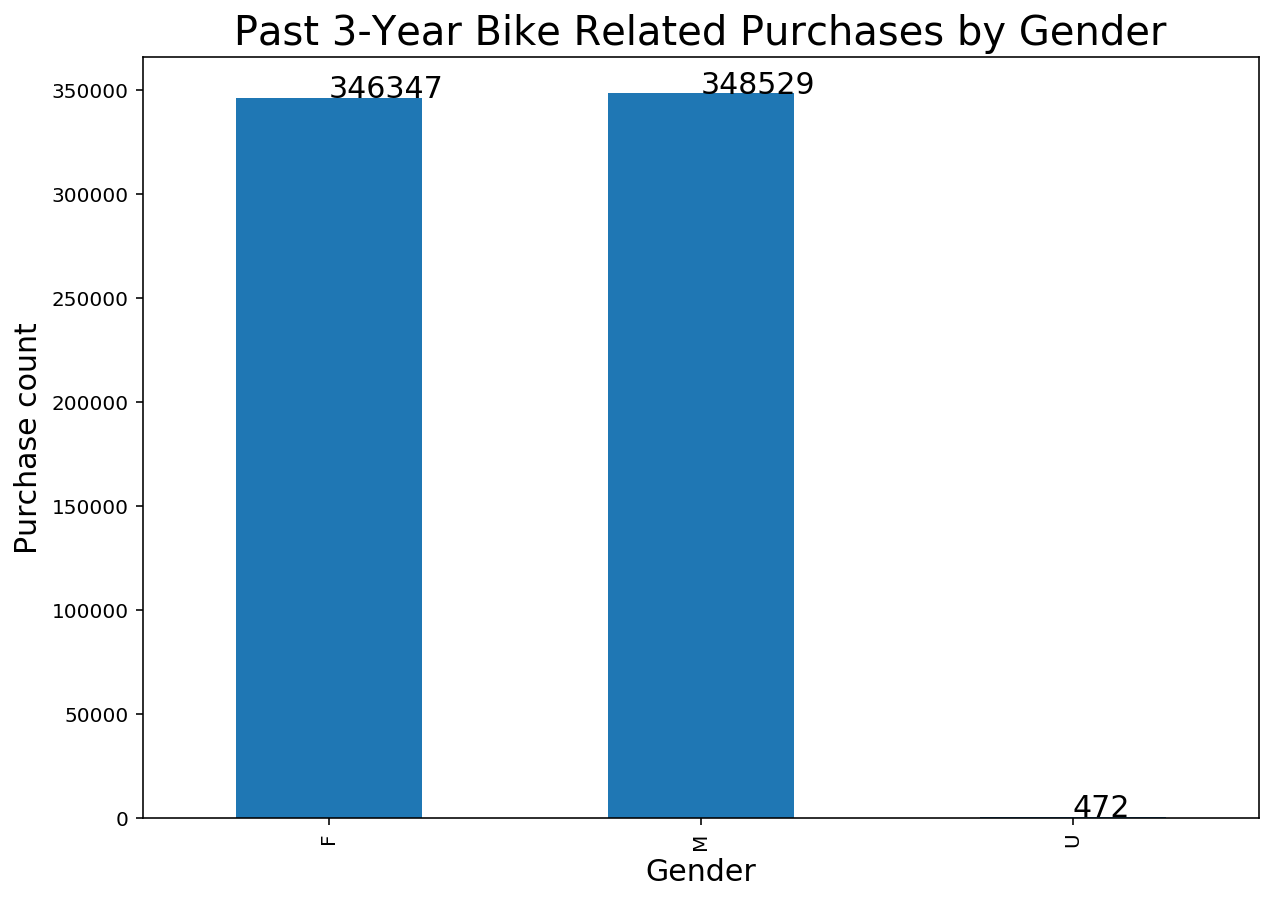

In [36]:
# by gender
ax = full_joined.groupby('gender')['past_3_years_bike_related_purchases'].sum();
ax.plot(kind='bar', figsize=[10,7])

for index,data in enumerate(ax):
    plt.text(x=index , y =data+2 , s=f"{data}" , fontdict=dict(fontsize=15))

plt.rc('xtick',labelsize=15)
plt.xlabel('Gender', size=15)
plt.ylabel('Purchase count', size=15)
plt.title('Past 3-Year Bike Related Purchases by Gender', size=20);

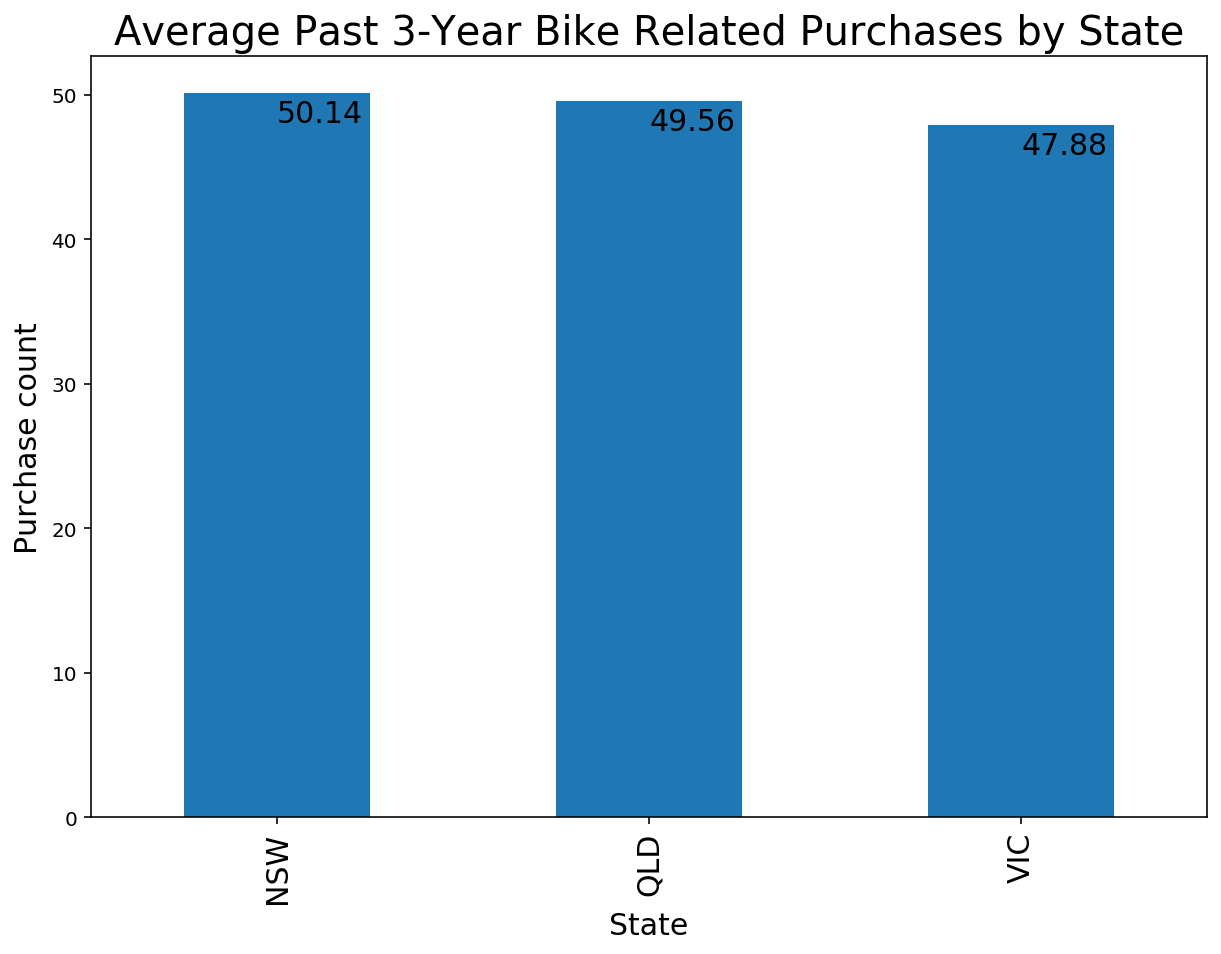

In [37]:
# By state
ax = full_joined.groupby('state')['past_3_years_bike_related_purchases'].mean();
ax.plot(kind='bar', figsize=[10,7])

for index,data in enumerate(ax):
    plt.text(x=index , y =data-2 , s=f"{data:.2f}" , fontdict=dict(fontsize=15))

plt.rc('xtick',labelsize=15)
plt.xlabel('State', size=15)
plt.ylabel('Purchase count', size=15)
plt.title('Average Past 3-Year Bike Related Purchases by State', size=20);

#### 2. Transactions

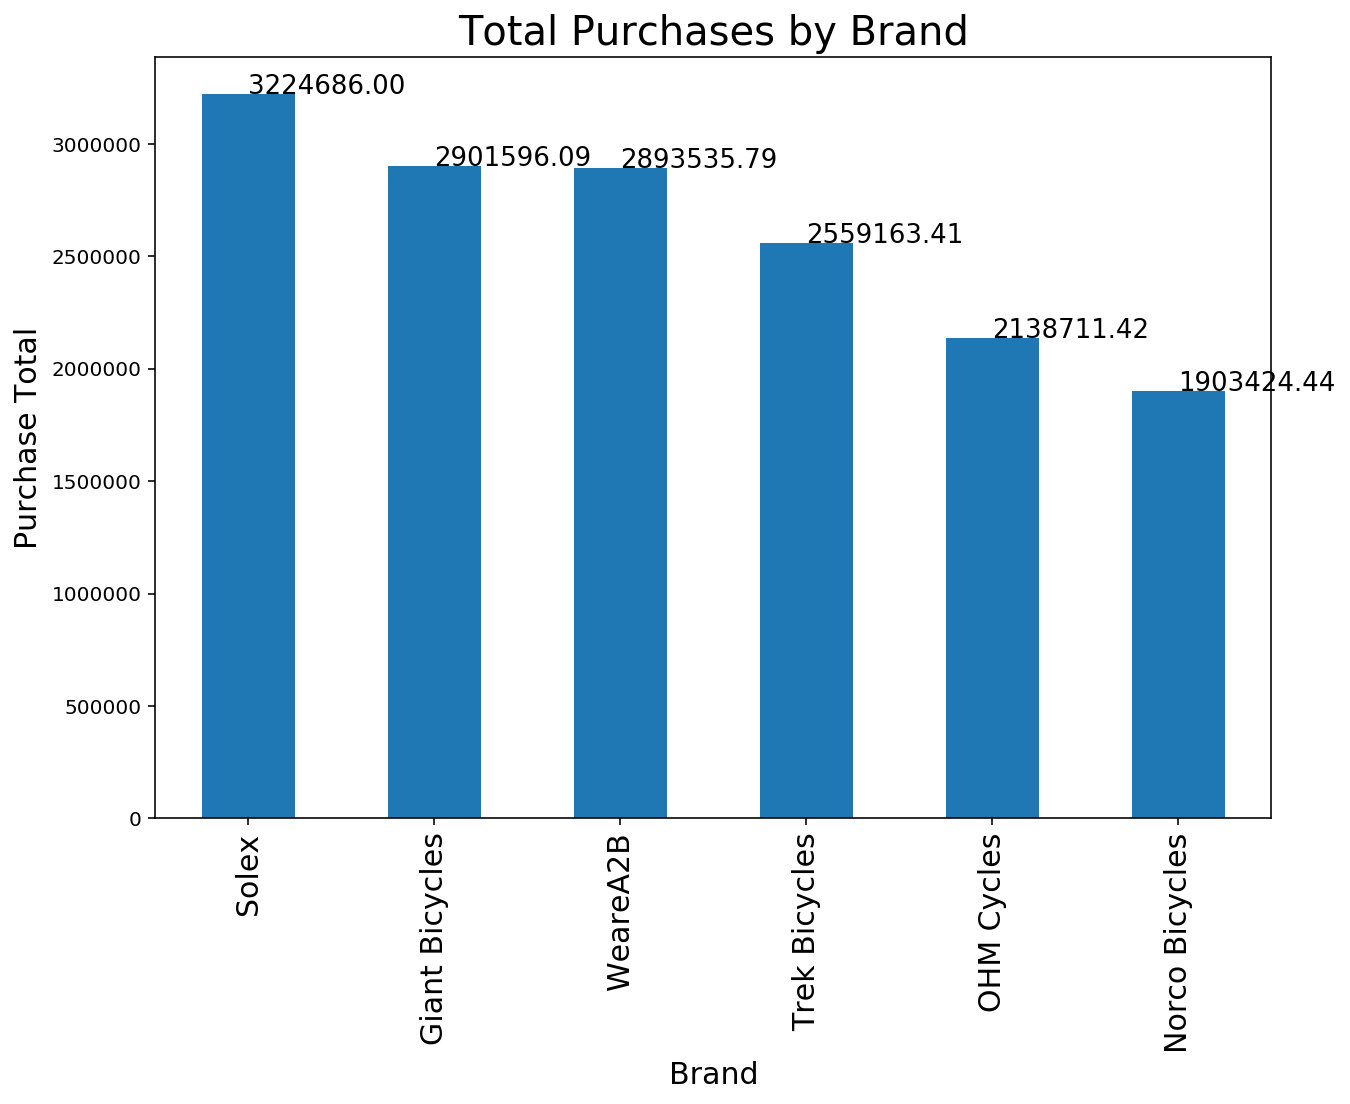

In [38]:
# by product Brand
ax = full_joined.groupby('brand')['list_price'].sum().sort_values(ascending=False);
ax.plot(kind='bar', figsize=[10,7])

for index,data in enumerate(ax):
    plt.text(x=index , y =data-2 , s=f"{data:.2f}" , fontdict=dict(fontsize=13))

plt.rc('xtick',labelsize=15)
plt.xlabel('Brand', size=15)
plt.ylabel('Purchase Total', size=15)
plt.title('Total Purchases by Brand', size=20);

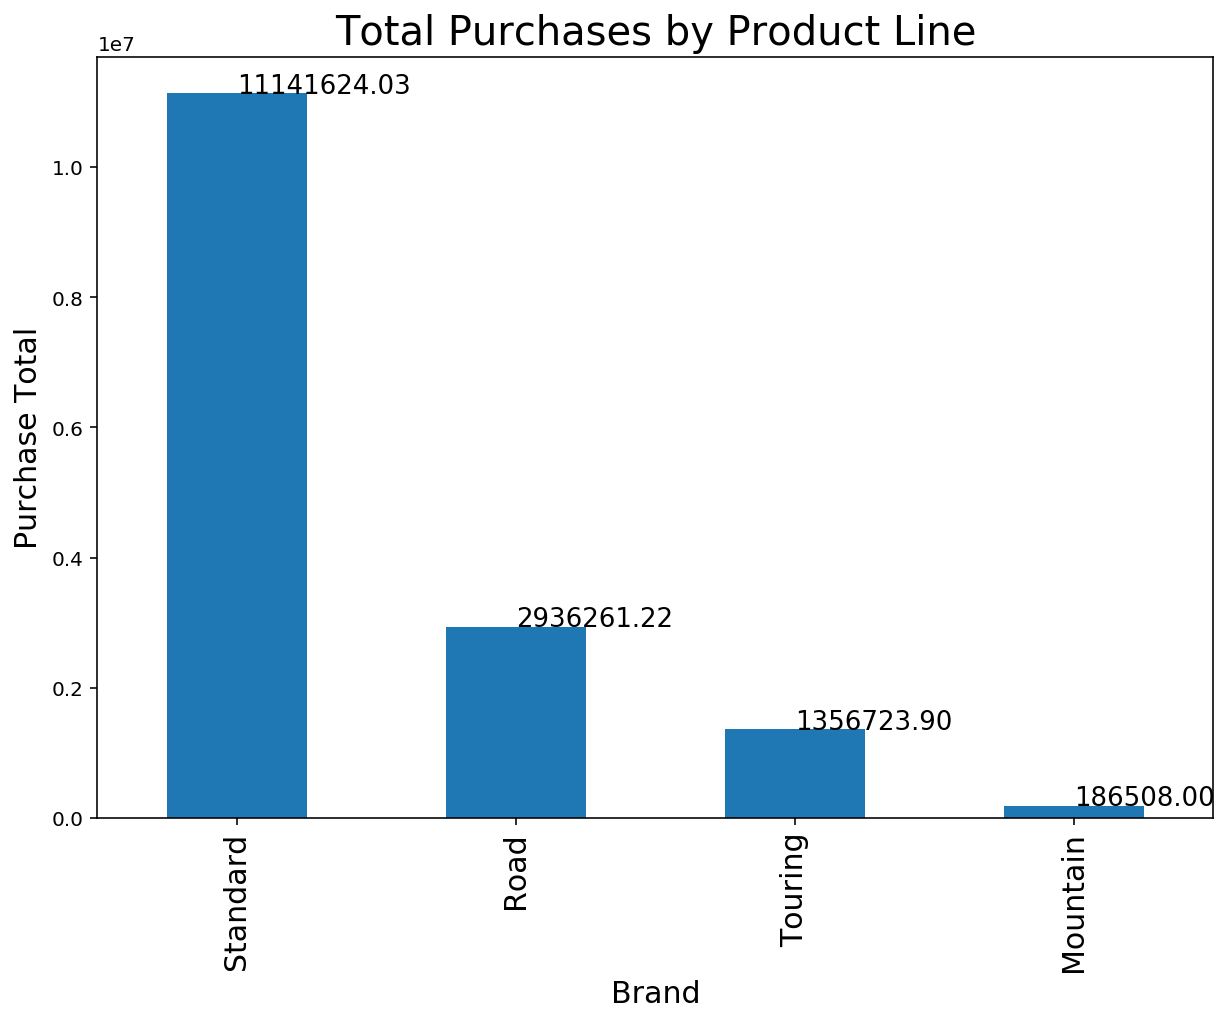

In [39]:
# By product line
ax = full_joined.groupby('product_line')['list_price'].sum().sort_values(ascending=False);
ax.plot(kind='bar', figsize=[10,7])

for index,data in enumerate(ax):
    plt.text(x=index , y =data-2 , s=f"{data:.2f}" , fontdict=dict(fontsize=13))

plt.rc('xtick',labelsize=15)
plt.xlabel('Brand', size=15)
plt.ylabel('Purchase Total', size=15)
plt.title('Total Purchases by Product Line', size=20);

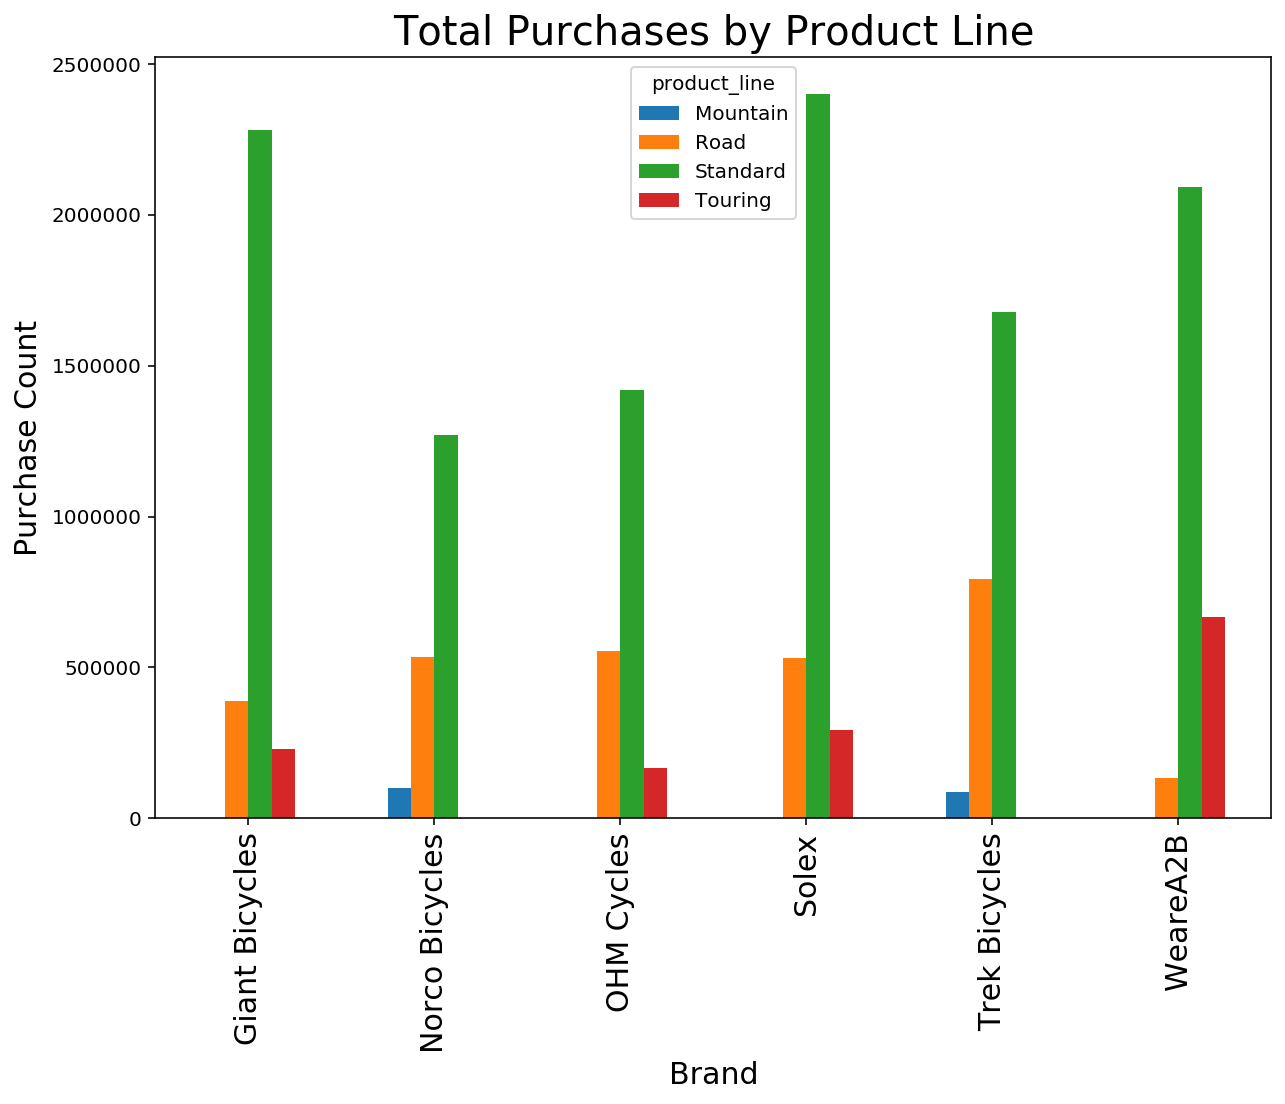

In [40]:
# By Product line and Brand
ax = full_joined.groupby(['brand','product_line'])['list_price'].sum().sort_values(ascending=False);
ax.unstack().plot(kind='bar', figsize=[10,7])

#for index,data in enumerate(ax):
    #plt.text(x=index , y =data-2 , s=f"{data:.2f}" , fontdict=dict(fontsize=13))

plt.rc('xtick',labelsize=15)
plt.xlabel('Brand', size=15)
plt.ylabel('Purchase Count', size=15)
plt.title('Total Purchases by Product Line', size=20);

#### 3. Customer Job distribution

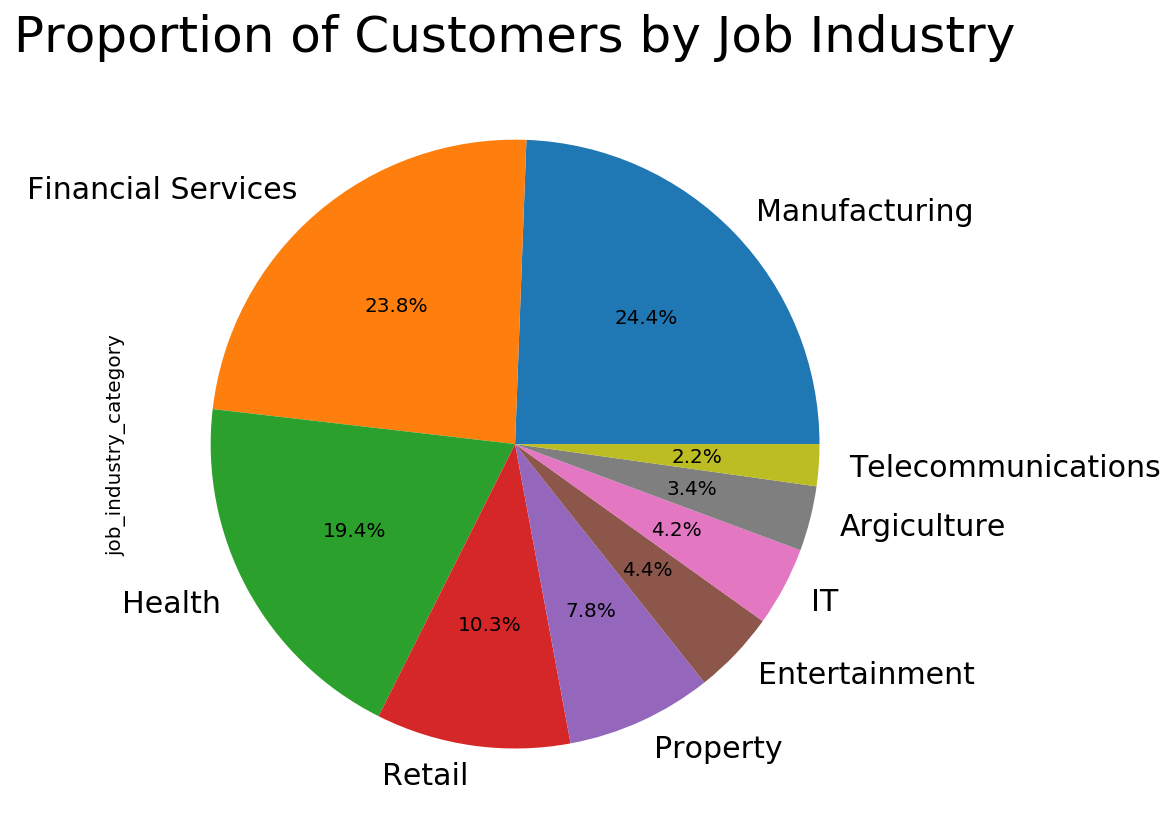

In [41]:
full_joined['job_industry_category'].value_counts().plot(kind='pie', figsize=[15,7], autopct='%1.1f%%');
plt.title('Proportion of Customers by Job Industry', size=25);


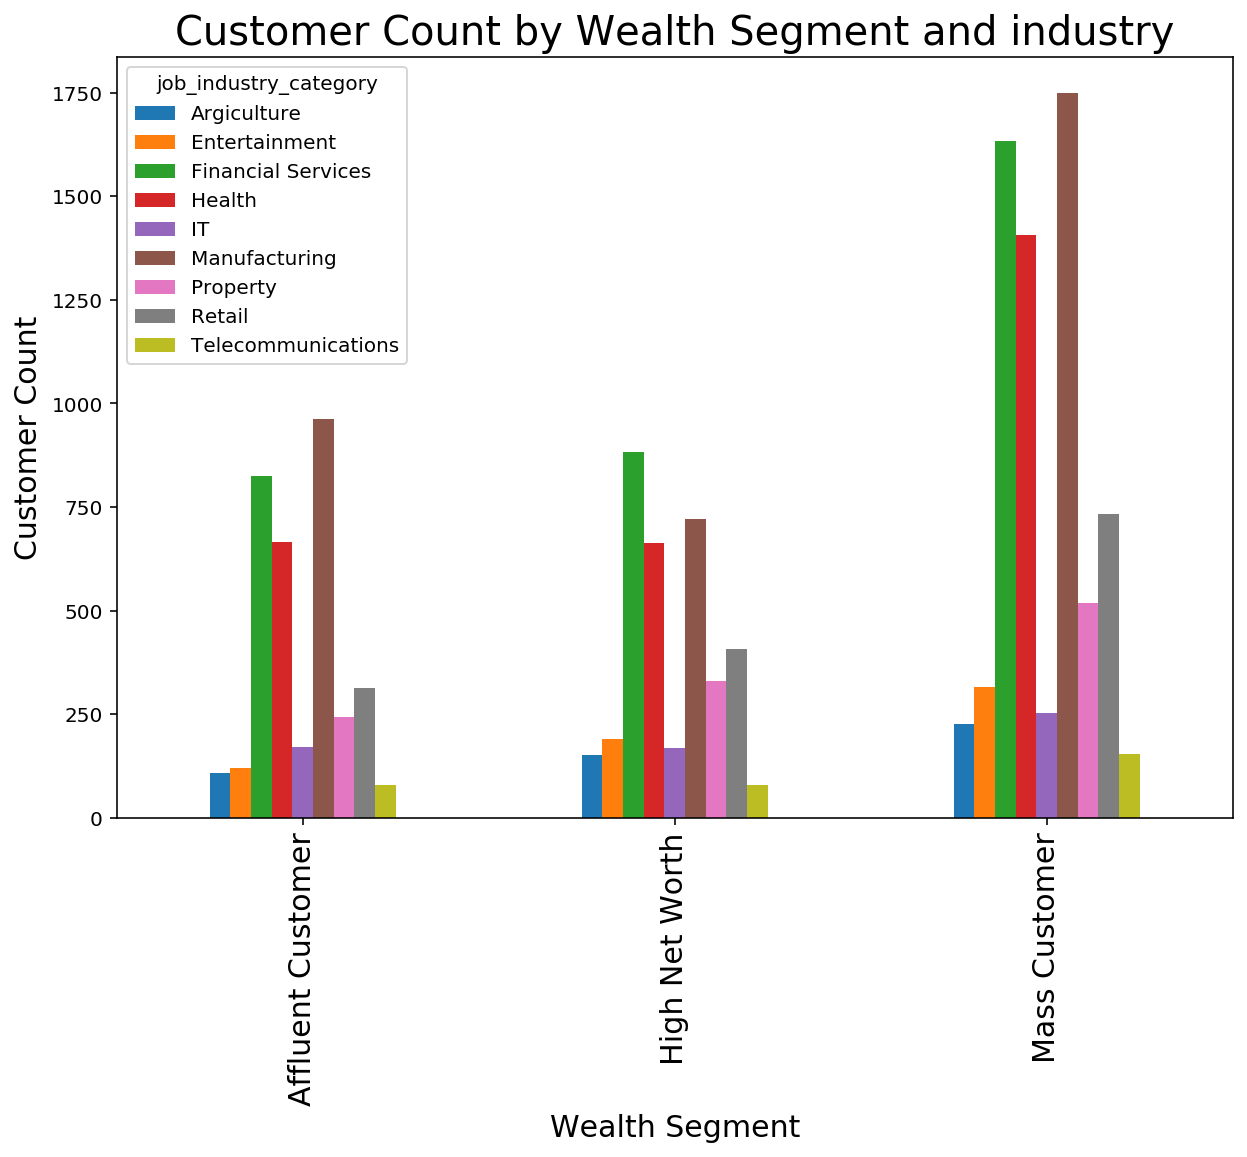

In [42]:
full_joined.groupby(['wealth_segment','job_industry_category']).count()['tenure'].unstack().plot(kind='bar', figsize=(10,7));
plt.xlabel('Wealth Segment', size=15)
plt.ylabel('Customer Count', size=15)
plt.title('Customer Count by Wealth Segment and industry', size=20);

#### 4. State

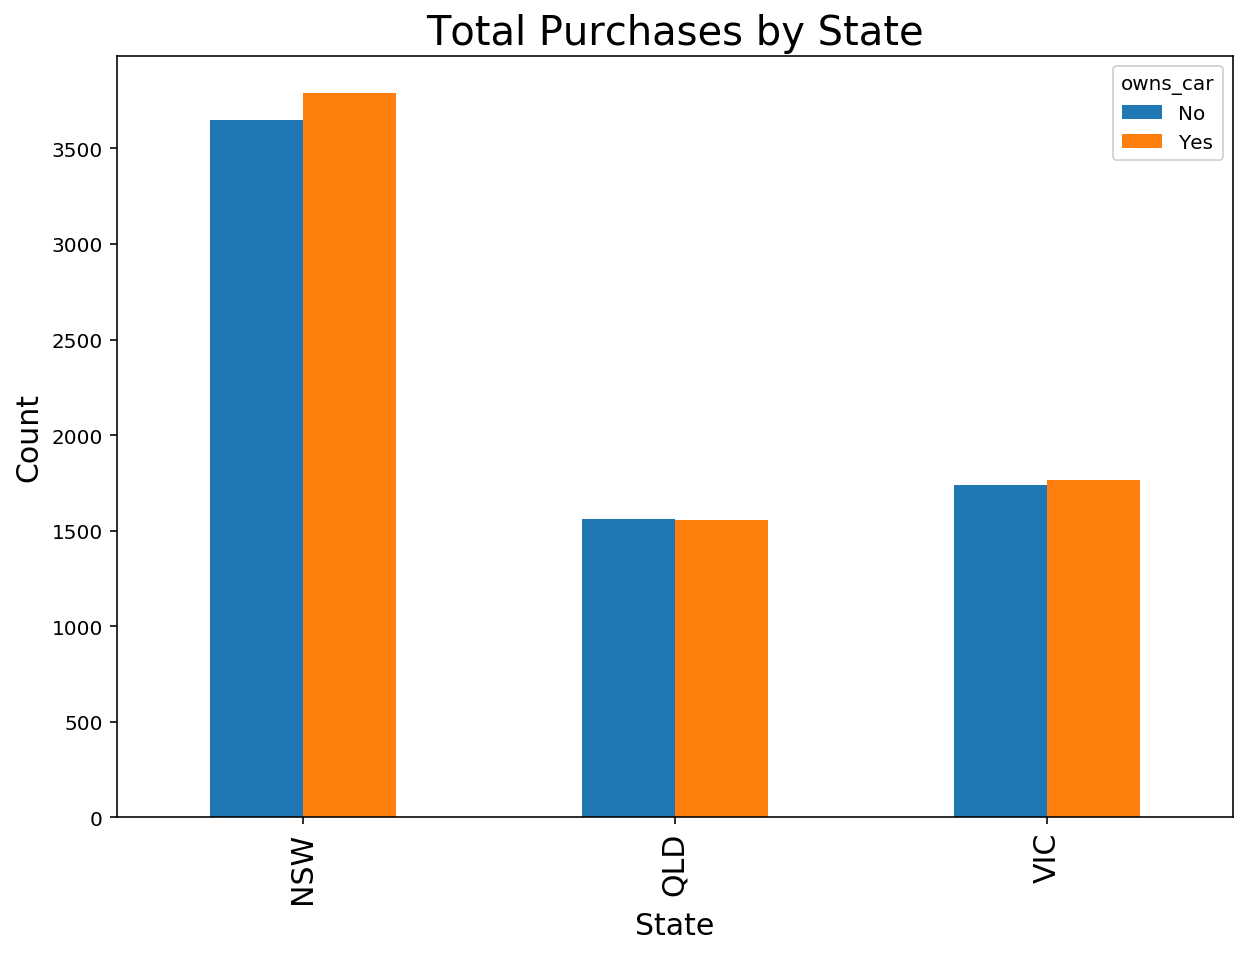

In [43]:
# Cars owned by state
full_joined.groupby(['state','owns_car']).count()['list_price'].unstack().plot(kind='bar', figsize=(10,7));
plt.xlabel('State', size=15)
plt.ylabel('Count', size=15)
plt.title('Total Purchases by State', size=20);

# Feature Engineering

- DOB to Age brackets
- Profit from List Price and Standard Cost
- Supplementary Data


In [44]:
def engineered_features(df):
    
    # Profit creation
    df['profit'] = df['list_price'] - df['standard_cost']
    
    # Age creation
    now = pd.Timestamp('now')
    df['age'] = (now - df['DOB']).astype('<m8[Y]') - 3
    
    # Transaction month creation
    df['transaction_month'] = df['transaction_date'].dt.month
    
    # Age group creation
    bins= [0,10,18,30,50,120]
    labels = ['Kid','Teen','Young adult','Middle Aged','Elderly']
    df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    df.drop(columns=['age','DOB'], inplace=True)
    return df
    
    

In [45]:
test = full_joined.copy()
full_engineered = engineered_features(test)

full_engineered.head(10)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,deceased_indicator,owns_car,tenure,address,postcode,state,property_valuation,profit,transaction_month,AgeGroup
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,...,N,Yes,10.0,984 Hoepker Court,3064,VIC,6,17.87,2,Elderly
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,...,N,Yes,10.0,984 Hoepker Court,3064,VIC,6,448.68,10,Elderly
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,...,N,Yes,10.0,984 Hoepker Court,3064,VIC,6,179.44,4,Elderly
3,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,1702.55,5,Middle Aged
4,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,medium,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,451.65,10,Middle Aged
5,9155,91,3120,2017-10-30,1.0,Approved,Solex,Standard,medium,medium,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,25.09,10,Middle Aged
6,11409,95,3120,2017-01-30,0.0,Approved,Giant Bicycles,Standard,medium,large,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,41.13,1,Middle Aged
7,13066,38,3120,2017-01-20,1.0,Approved,Solex,Standard,medium,medium,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,751.02,1,Middle Aged
8,15829,41,3120,2017-12-10,0.0,Approved,Solex,Road,medium,medium,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,104.24,12,Middle Aged
9,18612,10,3120,2017-10-24,0.0,Approved,WeareA2B,Touring,medium,medium,...,N,Yes,10.0,4 Shopko Circle,2196,NSW,5,1103.43,10,Middle Aged


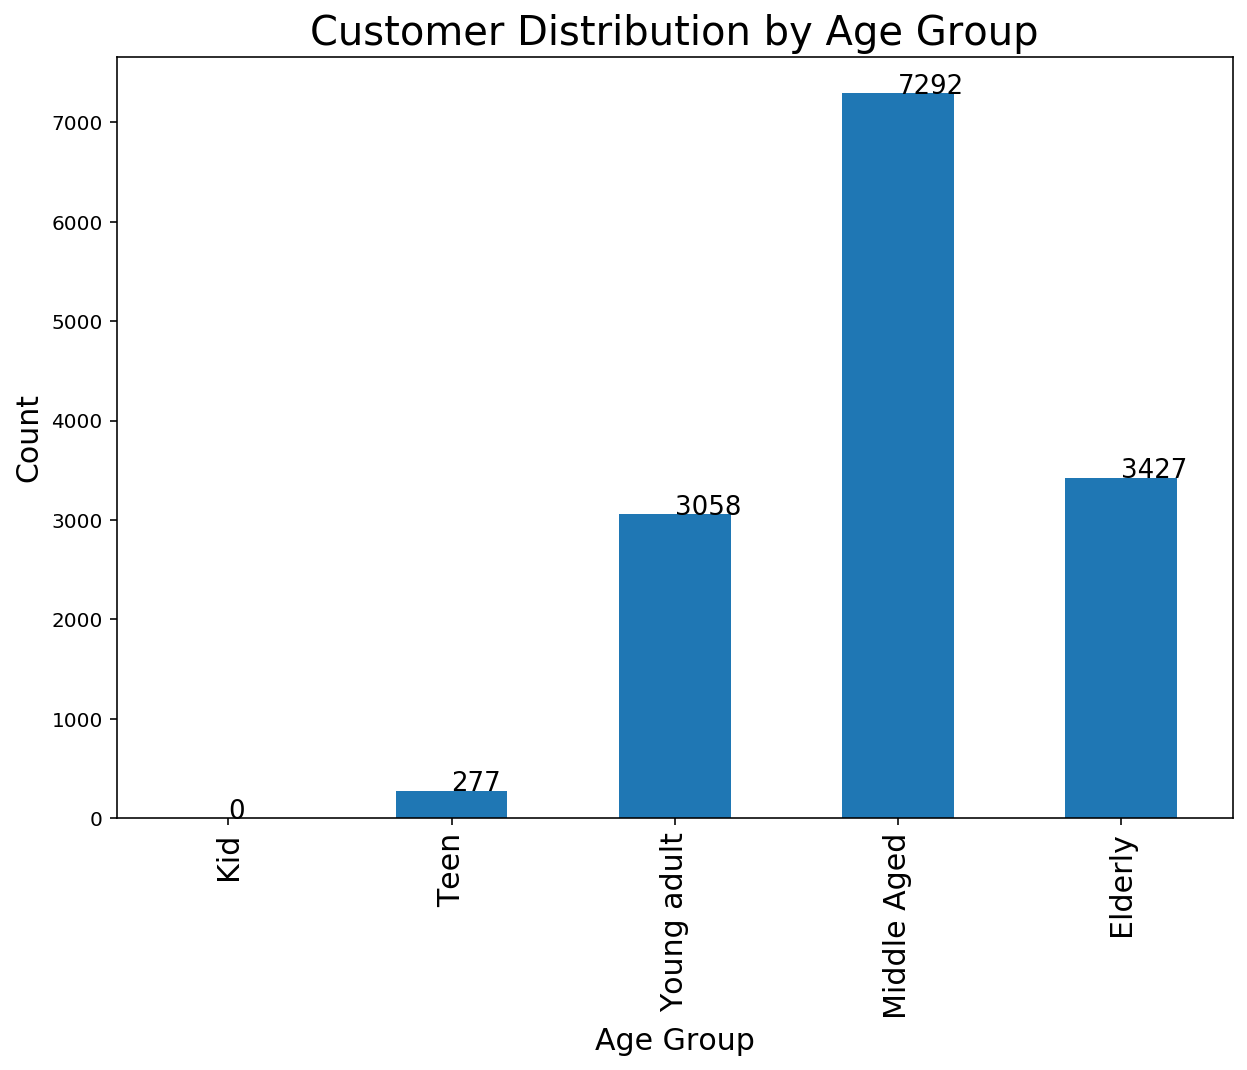

In [46]:
ax = full_engineered.groupby('AgeGroup')['customer_id'].count()
ax.plot(kind='bar', figsize=[10,7]);

for index,data in enumerate(ax):
    plt.text(x=index , y =data-2 , s=f"{data}" , fontdict=dict(fontsize=13))


plt.xlabel('Age Group', size=15)
plt.ylabel('Count', size=15)
plt.title('Customer Distribution by Age Group', size=20);


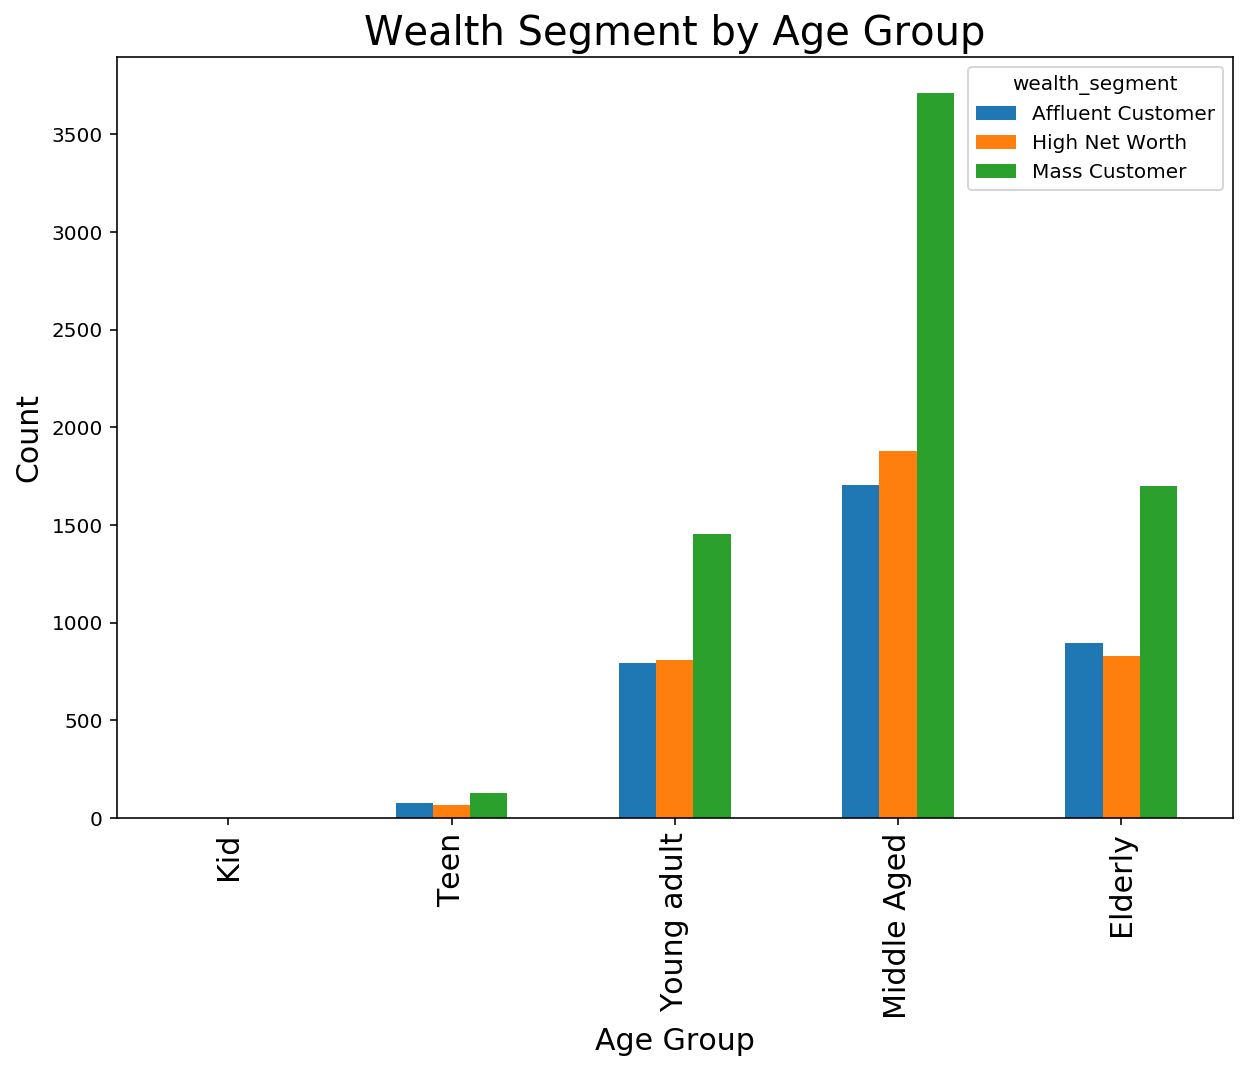

In [47]:
# Wealth Segment by Age
full_engineered.groupby(['AgeGroup','wealth_segment']).count()['list_price'].unstack().plot(kind='bar', figsize=(10,7));
plt.xlabel('Age Group', size=15)
plt.ylabel('Count', size=15)
plt.title('Wealth Segment by Age Group', size=20);

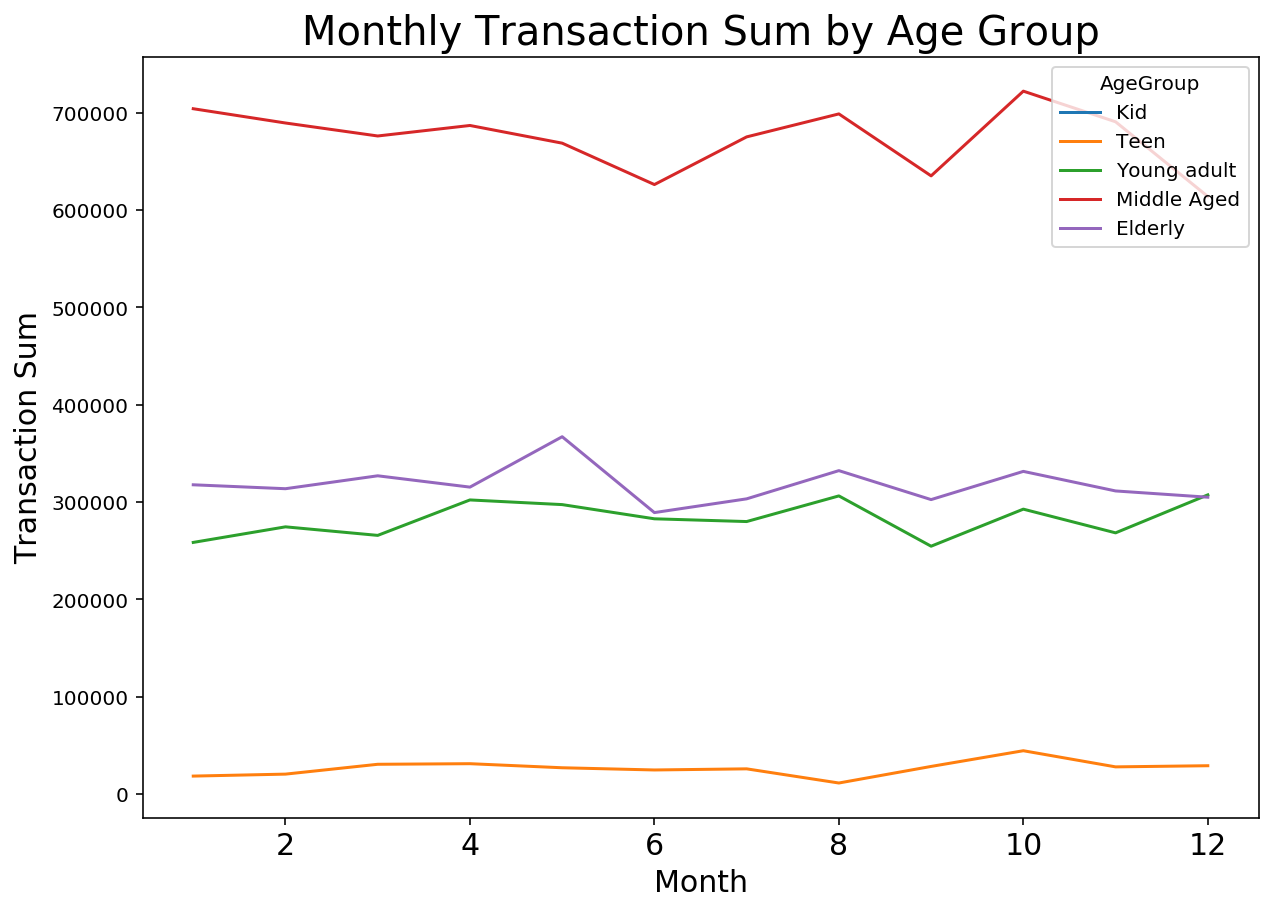

In [48]:
# Monthly Transaction by Age
full_engineered.groupby(['transaction_month','AgeGroup']).sum()['list_price'].unstack().plot(kind='line', figsize=(10,7));
plt.xlabel('Month', size=15)
plt.ylabel('Transaction Sum', size=15)
plt.title('Monthly Transaction Sum by Age Group', size=20);

# RFM Analysis

One way of analyzing customer behavior is by using the RFM model. RFM stands for Recency, Frequency and Monetary value. Each metric can be used to gain insight on aspects of customer behavior or customer life-cycle. 

- **Recency**: Indicates the freshness of customer activity. 
- **Frequency**: Indicates the regularity of customer transactions.
- **Monetary**: Indicates how much a customer is willing to or capable of spending.

RFM values can be used to find:

- Highest value customers
- Customers with potential to be high-value
- Loyal customers
- Customers at risk of being churned
- Customers already churned

### Build RFM Dataframe

In [49]:
last_day = full_engineered['transaction_date'].max().to_pydatetime().day + 1

RFM = full_engineered.groupby('customer_id').agg({'transaction_date': lambda x: last_day - x.max().to_pydatetime().day,
                                                  'transaction_id': 'count',
                                                  'list_price': lambda x: round(x.sum(), 2)})

RFM.columns = ['Recency', 'Frequency', 'Monetary']

In [50]:
RFM.head()

,Recency,Frequency,Monetary
customer_id,,,
1,8,11,9084.45
2,7,3,4149.07
9,18,6,5357.55
12,7,7,6394.21
13,28,7,7734.74


We can have a look at the data distribution using these three RFM measures

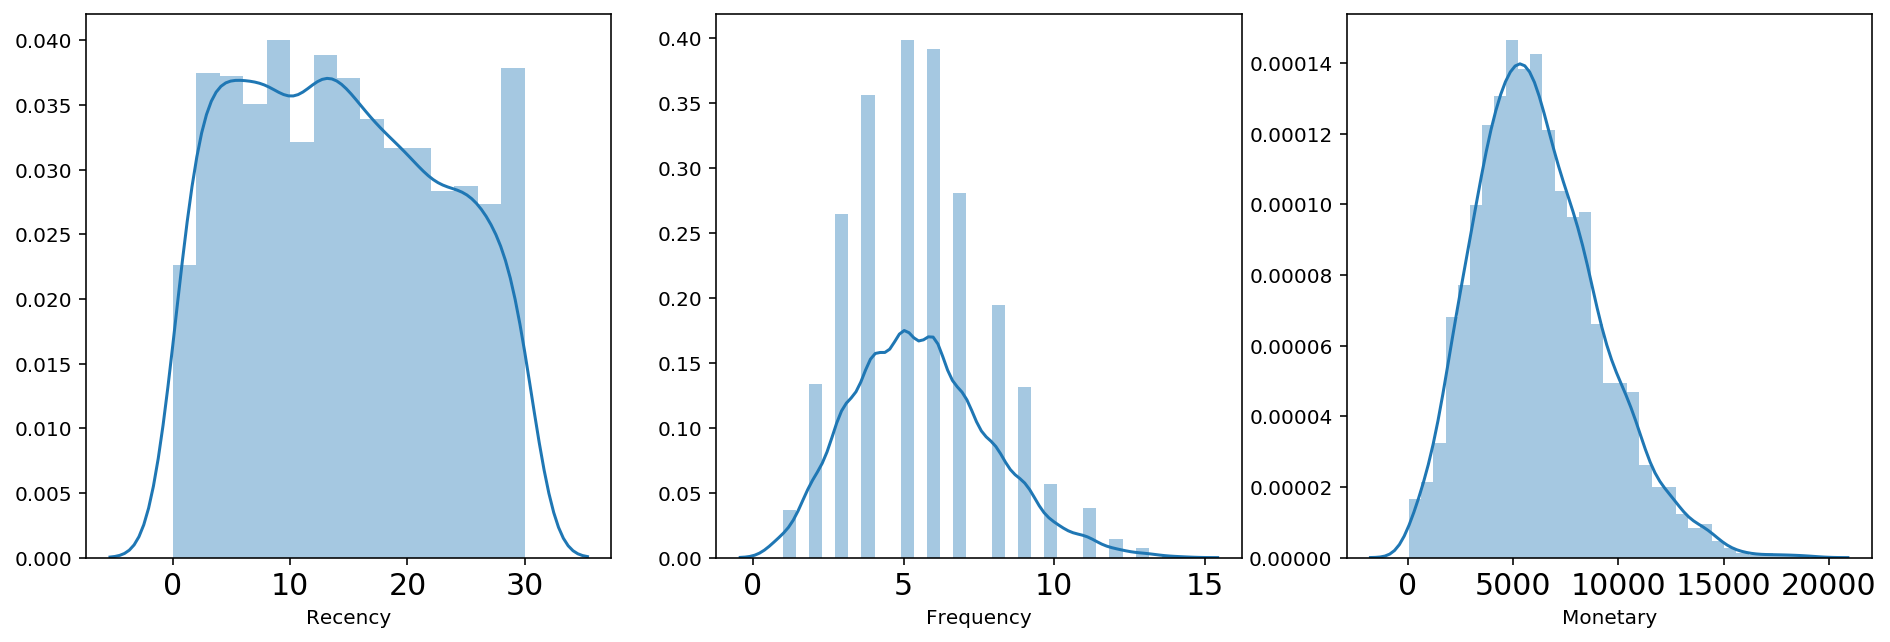

In [51]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
for n, att in enumerate(list(RFM.columns)):
    sns.distplot(RFM[att], ax=ax[n])
    ax[n].set_xlabel(str(att), size=10)

In [52]:
for a,b in enumerate(list(RFM.columns)):
    print(a,b)

0 Recency
1 Frequency
2 Monetary


In [53]:
### Create R, M and F scores

a = np.full((1, RFM.shape[0] - int((2/3)*RFM.shape[0])),1)

_33th_perc = int((1/3)*RFM.shape[0])

b = np.full((1, _33th_perc), 2)
c = np.full((1, _33th_perc), 3)

#d = np.full((1, _20th_perc), 4)
#e = np.full((1, _20th_perc), 5)

ind_score = np.hstack((a,b,c)).flatten()

In [54]:
RFM = RFM.sort_values(by='Recency', ascending=False)
RFM['R'] = ind_score

for m,n in zip(('Frequency','Monetary'),('F','M')):
    RFM = RFM.sort_values(by=m)
    RFM[n] = ind_score

RFM

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
3292,27,1,60.34,1,1,1
2274,26,2,142.98,1,1,1
3189,27,2,200.70,1,1,1
2423,30,1,202.62,1,1,1
1204,18,1,235.63,2,1,1
...,...,...,...,...,...,...
1302,30,13,17035.83,1,3,3
2788,15,11,17258.94,2,3,3
941,4,10,17898.46,3,3,3


In [55]:
RFM['RFMscore'] = RFM.R.map(str) + RFM.F.map(str) + RFM.M.map(str)

In [56]:
RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFMscore
customer_id,,,,,,,
3292,27,1,60.34,1,1,1,111
2274,26,2,142.98,1,1,1,111
3189,27,2,200.70,1,1,1,111
2423,30,1,202.62,1,1,1,111
1204,18,1,235.63,2,1,1,211


In [57]:
RFM.describe()

,Recency,Frequency,Monetary,R,F,M
count,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000
mean,14.338090,5.573524,6191.485196,2.000000,2.000000,2.000000
std,8.518967,2.276236,2938.675616,0.816658,0.816658,0.816658
min,0.000000,1.000000,60.340000,1.000000,1.000000,1.000000
25%,7.000000,4.000000,4080.105000,1.000000,1.000000,1.000000
50%,14.000000,5.000000,5874.840000,2.000000,2.000000,2.000000
75%,21.000000,7.000000,8004.325000,3.000000,3.000000,3.000000
max,30.000000,14.000000,19071.320000,3.000000,3.000000,3.000000


## Cluster Analysis

In [58]:
X = RFM.loc[:, "R":"M"]
X.head()

,R,F,M
customer_id,,,
3292,1,1,1
2274,1,1,1
3189,1,1,1
2423,1,1,1
1204,2,1,1


In [59]:
model = KMeans(n_clusters=4, random_state=7)
model.fit(X)

cluster_labels = model.labels_

centroids = model.cluster_centers_

X['cluster'] = cluster_labels


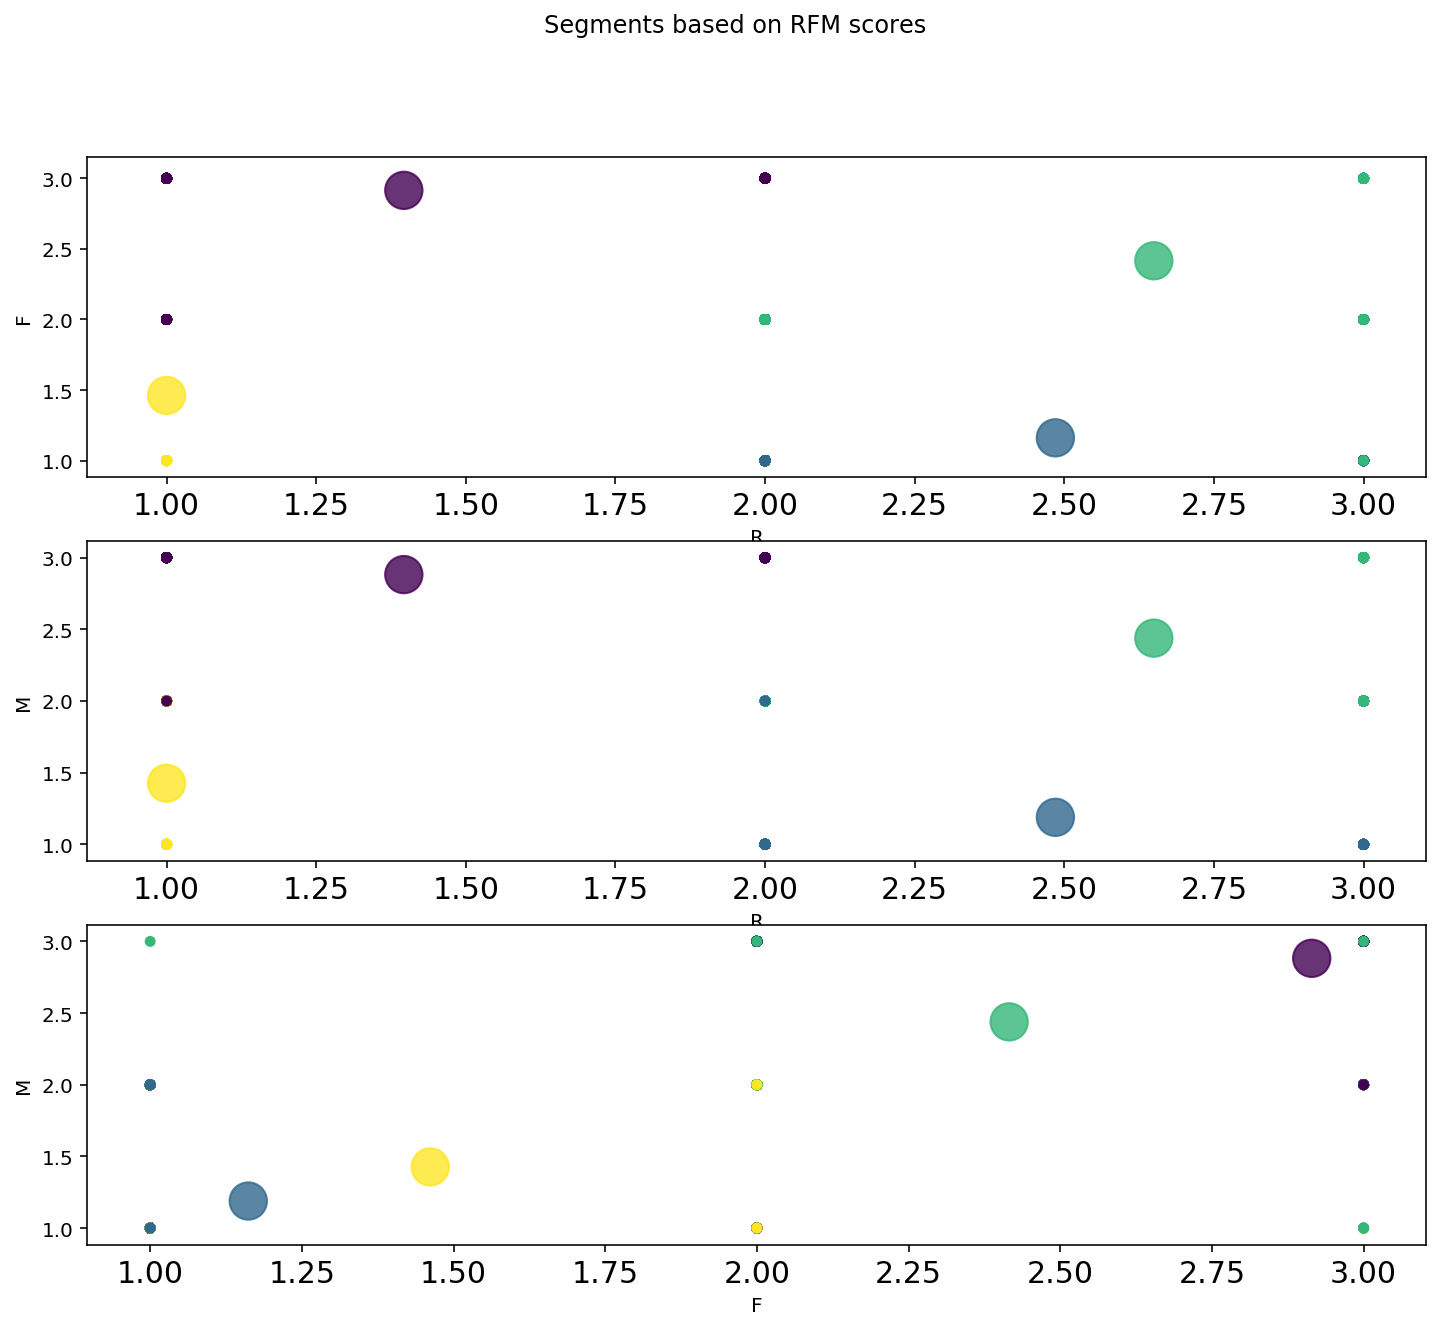

In [60]:
k=4
# Scatter plot of data coloured by cluster they belong to
fig, (ax4, ax5, ax6) = plt.subplots(3);

fig.suptitle('Segments based on RFM scores');

X.plot.scatter(x = 'R', y = 'F', c=X['cluster'], colormap='viridis', ax=ax4, colorbar=False,figsize = (12,10));
ax4.scatter(centroids[:,0], centroids[:,1], marker='o', s=350, alpha=.8, c=range(0,k), 
            cmap='viridis');

X.plot.scatter(x = 'R', y = 'M', c=X['cluster'], colormap='viridis', ax=ax5, colorbar=False);
ax5.scatter(centroids[:,0], centroids[:,2], marker='o', s=350, alpha=.8, c=range(0,k), 
            cmap='viridis');

X.plot.scatter(x = 'F', y = 'M', c=X['cluster'], colormap='viridis', ax=ax6, colorbar=False);
ax6.scatter(centroids[:,1], centroids[:,2], marker='o', s=350, alpha=.8, c=range(0,k), 
            cmap='viridis');

In [61]:
X.head()

,R,F,M,cluster
customer_id,,,,
3292,1,1,1,3
2274,1,1,1,3
3189,1,1,1,3
2423,1,1,1,3
1204,2,1,1,1


In [62]:
RFM['cluster'] = cluster_labels

In [63]:
RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFMscore,cluster
customer_id,,,,,,,,
3292,27,1,60.34,1,1,1,111,3
2274,26,2,142.98,1,1,1,111,3
3189,27,2,200.70,1,1,1,111,3
2423,30,1,202.62,1,1,1,111,3
1204,18,1,235.63,2,1,1,211,1


In [64]:
RFM.groupby('cluster').agg({'Recency':['mean', 'min', 'max', 'count'],
                            'Frequency':['mean', 'min', 'max', 'count'],
                            'Monetary': ['mean', 'min', 'max', 'count']})

Recency               Frequency                   Monetary  \
              mean min max count      mean min max count         mean   
cluster                                                                 
0        20.205455   9  30   550  7.912727   5  14   550  9250.921164   
1         9.559880   0  19   668  3.520958   1   6   668  3610.399760   
2         7.981156   0  19   796  6.618090   4  14   796  7488.905729   
3        24.210216  19  30   509  4.106090   1   7   509  4243.997073   

                                  
             min       max count  
cluster                           
0        4848.03  18349.27   550  
1         235.63   7191.20   668  
2        3369.77  19071.32   796  
3          60.34   7189.50   509

## Cluster Analysis Interpretation

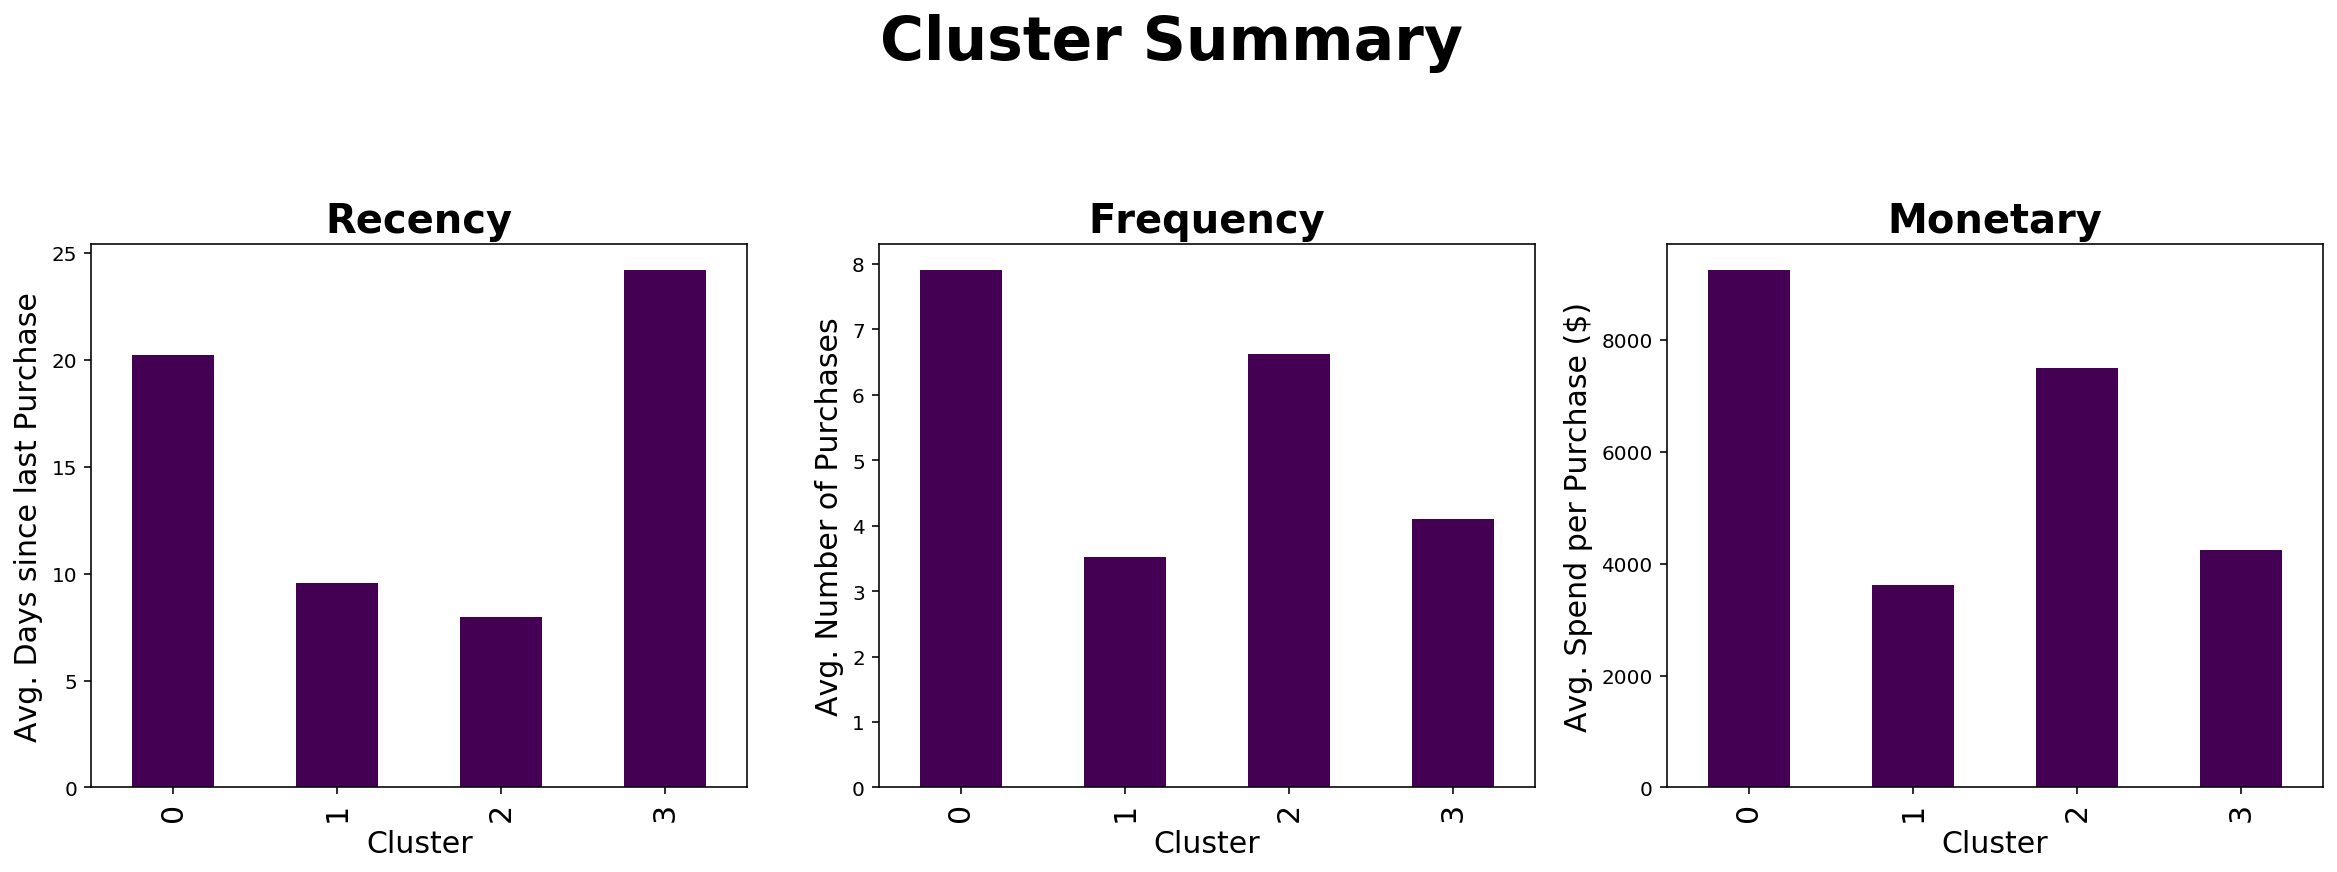

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Cluster Summary', size=30, fontweight='bold', y=1.2);

cluster_data = RFM.groupby('cluster')

cluster_data['Recency'].mean().plot.bar(x='cluster', colormap='viridis', ax=ax1)
ax1.set_title('Recency',fontweight="bold", size=20) 
ax1.set_ylabel('Avg. Days since last Purchase', fontsize = 15) 
ax1.set_xlabel('Cluster', fontsize = 15) 

cluster_data['Frequency'].mean().plot.bar(x='cluster', colormap='viridis', ax=ax2)
ax2.set_title('Frequency',fontweight="bold", size=20) # Title
ax2.set_ylabel('Avg. Number of Purchases', fontsize = 15) 
ax2.set_xlabel('Cluster', fontsize = 15) 

cluster_data['Monetary'].mean().plot.bar(x='cluster', colormap='viridis', ax=ax3);
ax3.set_title('Monetary',fontweight="bold", size=20) 
ax3.set_ylabel('Avg. Spend per Purchase ($)', fontsize = 15) 
ax3.set_xlabel('Cluster', fontsize = 15);

From the chart above, we can identify each cluster in terms of customer segments.

**Cluster 0**: 
 - Low recency, i.e high number of days since last purchase
 - High frequency, i.e high number of transactions within the examined time period
 - High average spend per purchase
 
 This segment represents **At Risk** customers, since a lack of recent activity for a frequent and heavy spender might indicate the customer has taken their patronage elsewhere.
 
 
**Cluster 1**: 
 - High recency, i.e short while since last purchase
 - Low frequency, i.e low number of transactions within the examined time period
 - Low average spend per purchase
 
 This segment represents **New** customers to the business. 
 
 
**Cluster 2**: 
 - High recency, i.e short while since last purchase
 - High frequency, i.e high number of transactions within the examined time period
 - High average spend per purchase
 
 This segment represents the **Highest Value** customers.
 
 
**Cluster 3**: 
 - Low recency, i.e A long while since last purchase
 - Low frequency, i.e low number of transactions within the examined time period
 - Low average spend per purchase
 
 This segment represents **potentially lost** customers, who at present, are of least value to the business.


# Highest Value Segment Exploration

In [66]:
# First we combine the cluster-labelled dataset to our original dataset
full_clustered = full_engineered.merge(RFM.reset_index()[['customer_id','cluster']], 
                                       left_on='customer_id', 
                                       right_on='customer_id')

full_clustered.head(3)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,owns_car,tenure,address,postcode,state,property_valuation,profit,transaction_month,AgeGroup,cluster
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,...,Yes,10.0,984 Hoepker Court,3064,VIC,6,17.87,2,Elderly,1
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,...,Yes,10.0,984 Hoepker Court,3064,VIC,6,448.68,10,Elderly,1
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,...,Yes,10.0,984 Hoepker Court,3064,VIC,6,179.44,4,Elderly,1


In [67]:
target_customers = full_clustered.loc[full_clustered['cluster'] == 2]
target_customers.shape

(5268, 31)

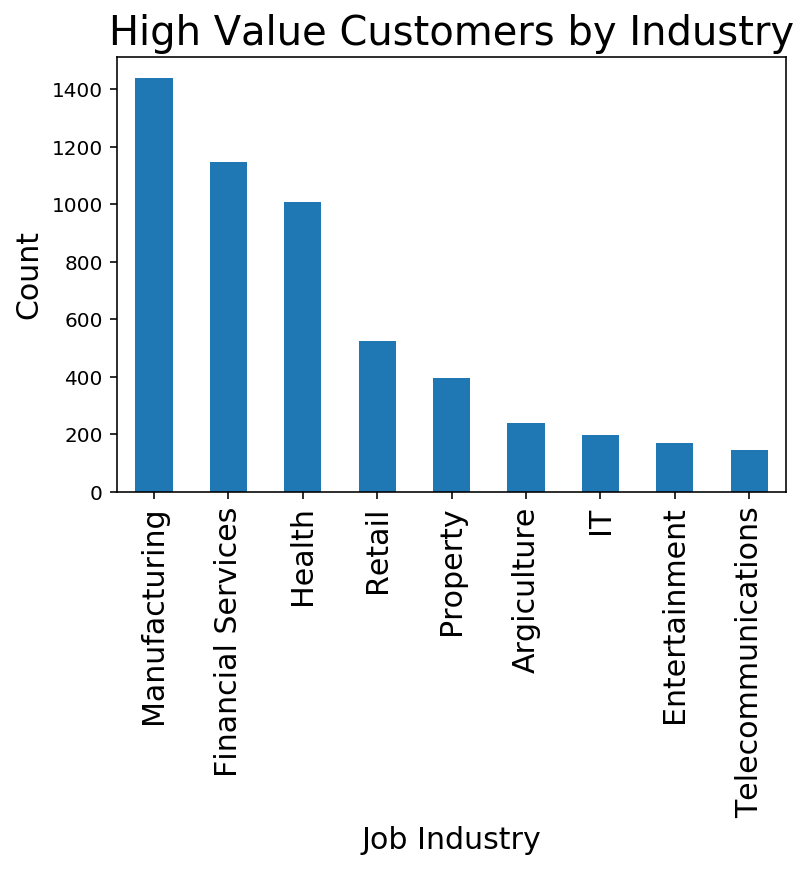

In [68]:
target_customers.groupby('job_industry_category')['transaction_id'].count().sort_values(ascending=False).plot(kind='bar'); 
plt.xlabel('Job Industry', size=15)
plt.ylabel('Count', size=15)
plt.title('High Value Customers by Industry', size=20);                                                                                

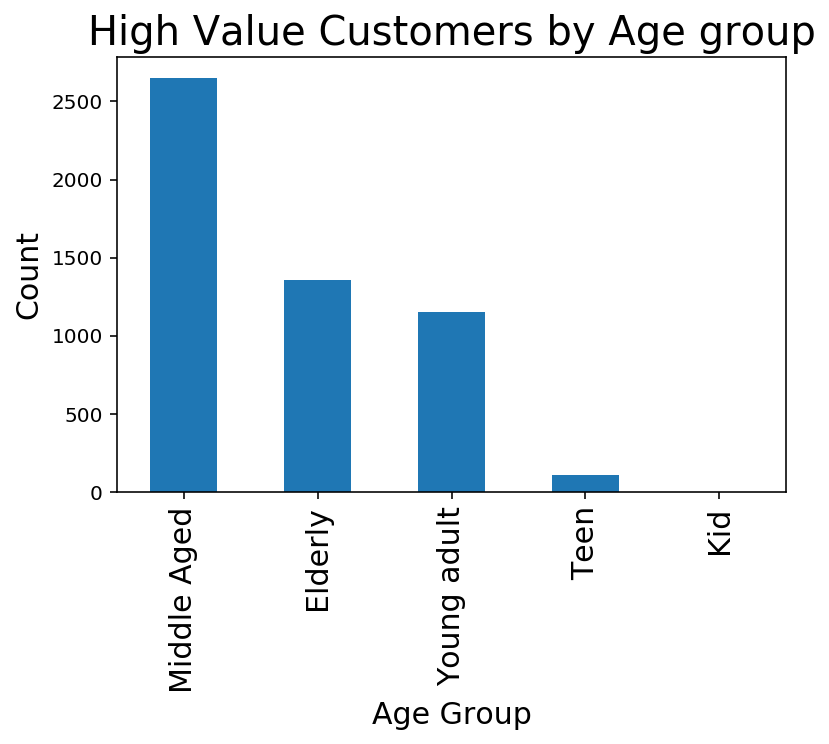

In [69]:
target_customers.groupby('AgeGroup')['transaction_id'].count().sort_values(ascending=False).plot(kind='bar'); 
plt.xlabel('Age Group', size=15)
plt.ylabel('Count', size=15)
plt.title('High Value Customers by Age group', size=20);                                                                                

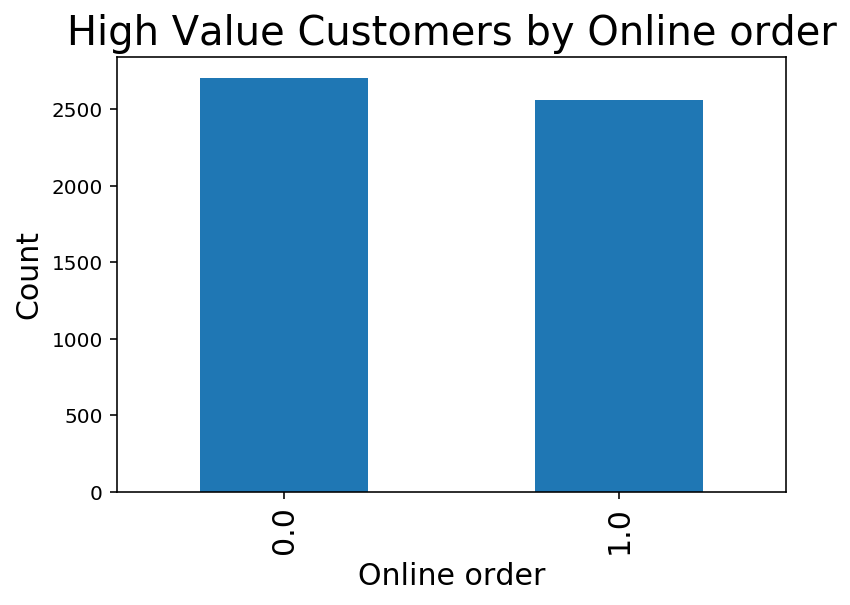

In [70]:
target_customers.groupby('online_order')['transaction_id'].count().sort_values(ascending=False).plot(kind='bar'); 
plt.xlabel('Online order', size=15)
plt.ylabel('Count', size=15)
plt.title('High Value Customers by Online order', size=20);                                                                                

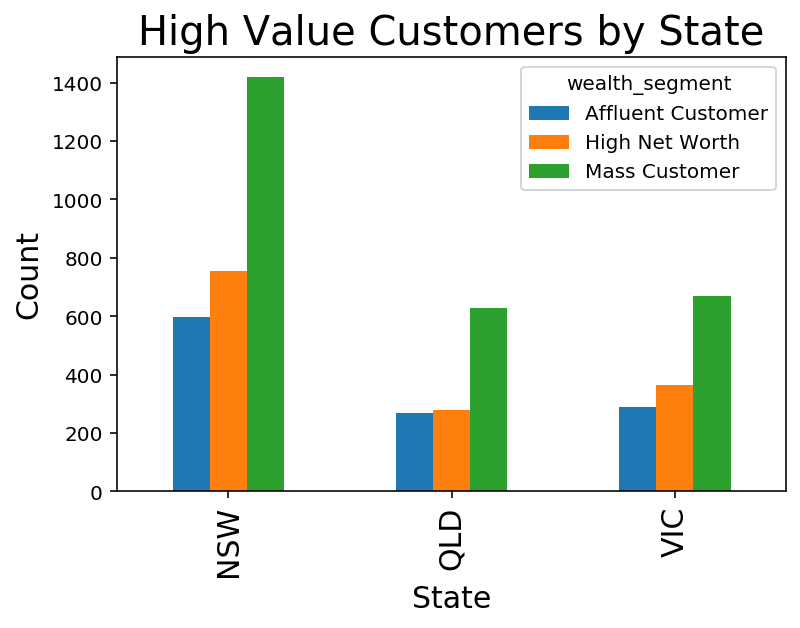

In [71]:
target_customers.groupby(['state','wealth_segment'])['transaction_id'].count().sort_values(ascending=False).unstack().plot(kind='bar'); 
plt.xlabel('State', size=15)
plt.ylabel('Count', size=15)
plt.title('High Value Customers by State', size=20);                                                                                

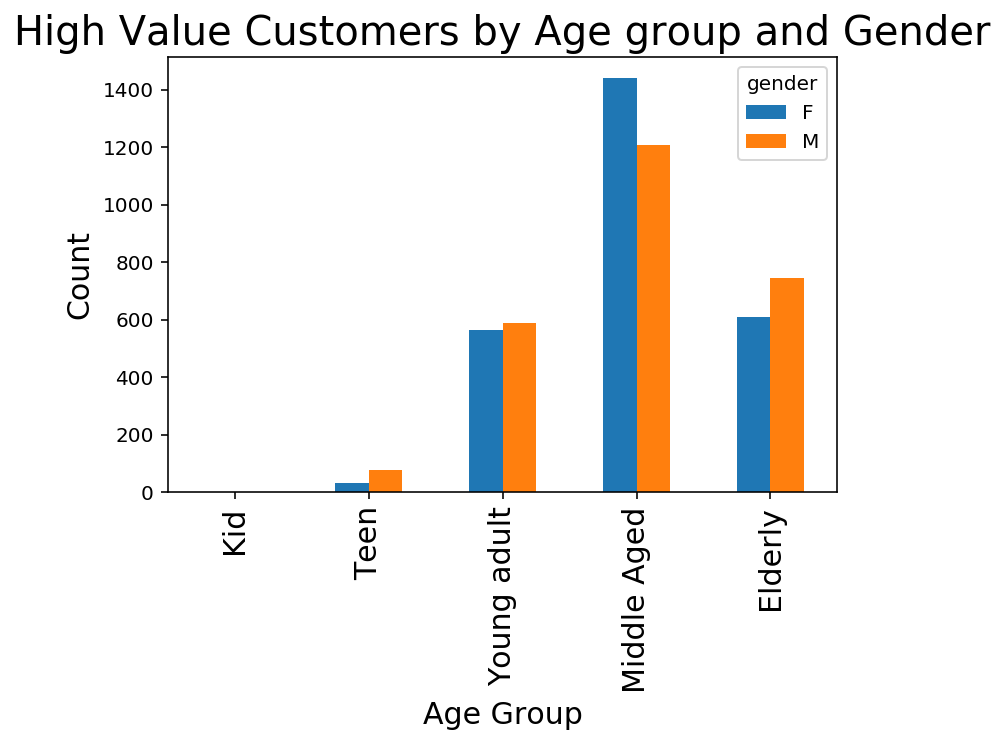

In [72]:
target_customers.groupby(['AgeGroup','gender'])['transaction_id'].count().sort_values(ascending=False).unstack().plot(kind='bar'); 
plt.xlabel('Age Group', size=15)
plt.ylabel('Count', size=15)
plt.title('High Value Customers by Age group and Gender', size=20);                                                                                

Here we see that the highest value customers closely follow the overall age group distribution for the entire dataset.

However by also segmenting this age distribution by gender, we observe that **middle-aged females** are the highest value customers. Next are the elderly males followed by their female counterparts.


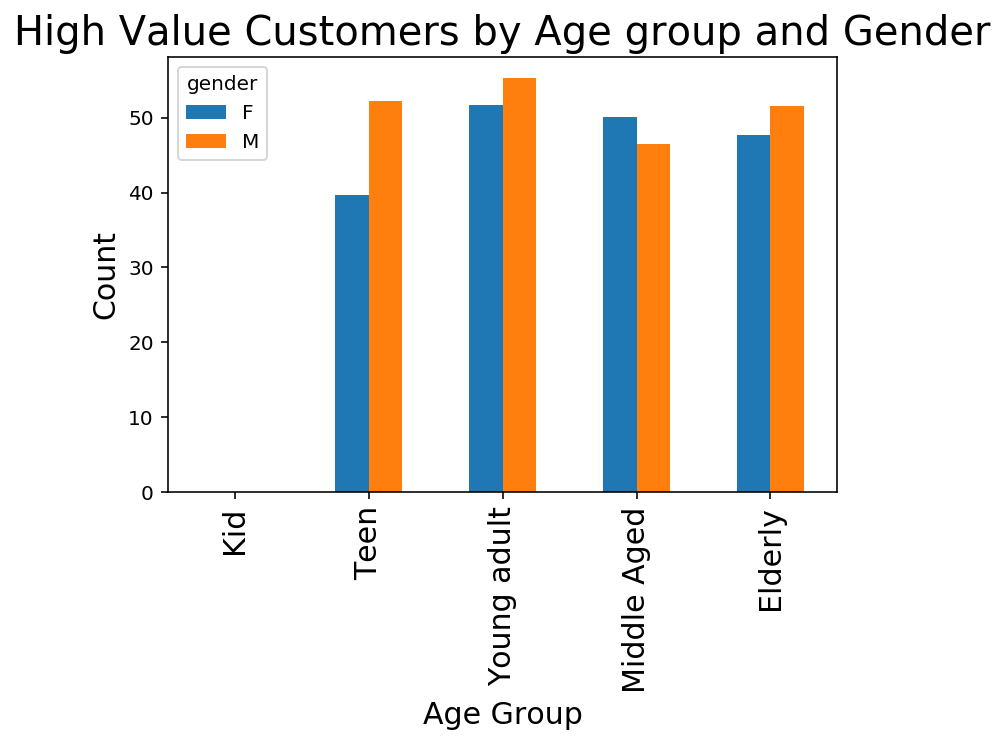

In [73]:
target_customers.groupby(['AgeGroup','gender'])['past_3_years_bike_related_purchases'].mean().sort_values(ascending=False).unstack().plot(kind='bar'); 
plt.xlabel('Age Group', size=15)
plt.ylabel('Count', size=15)
plt.title('High Value Customers by Age group and Gender', size=20); 





Text(0.5, 0, 'Age Group')

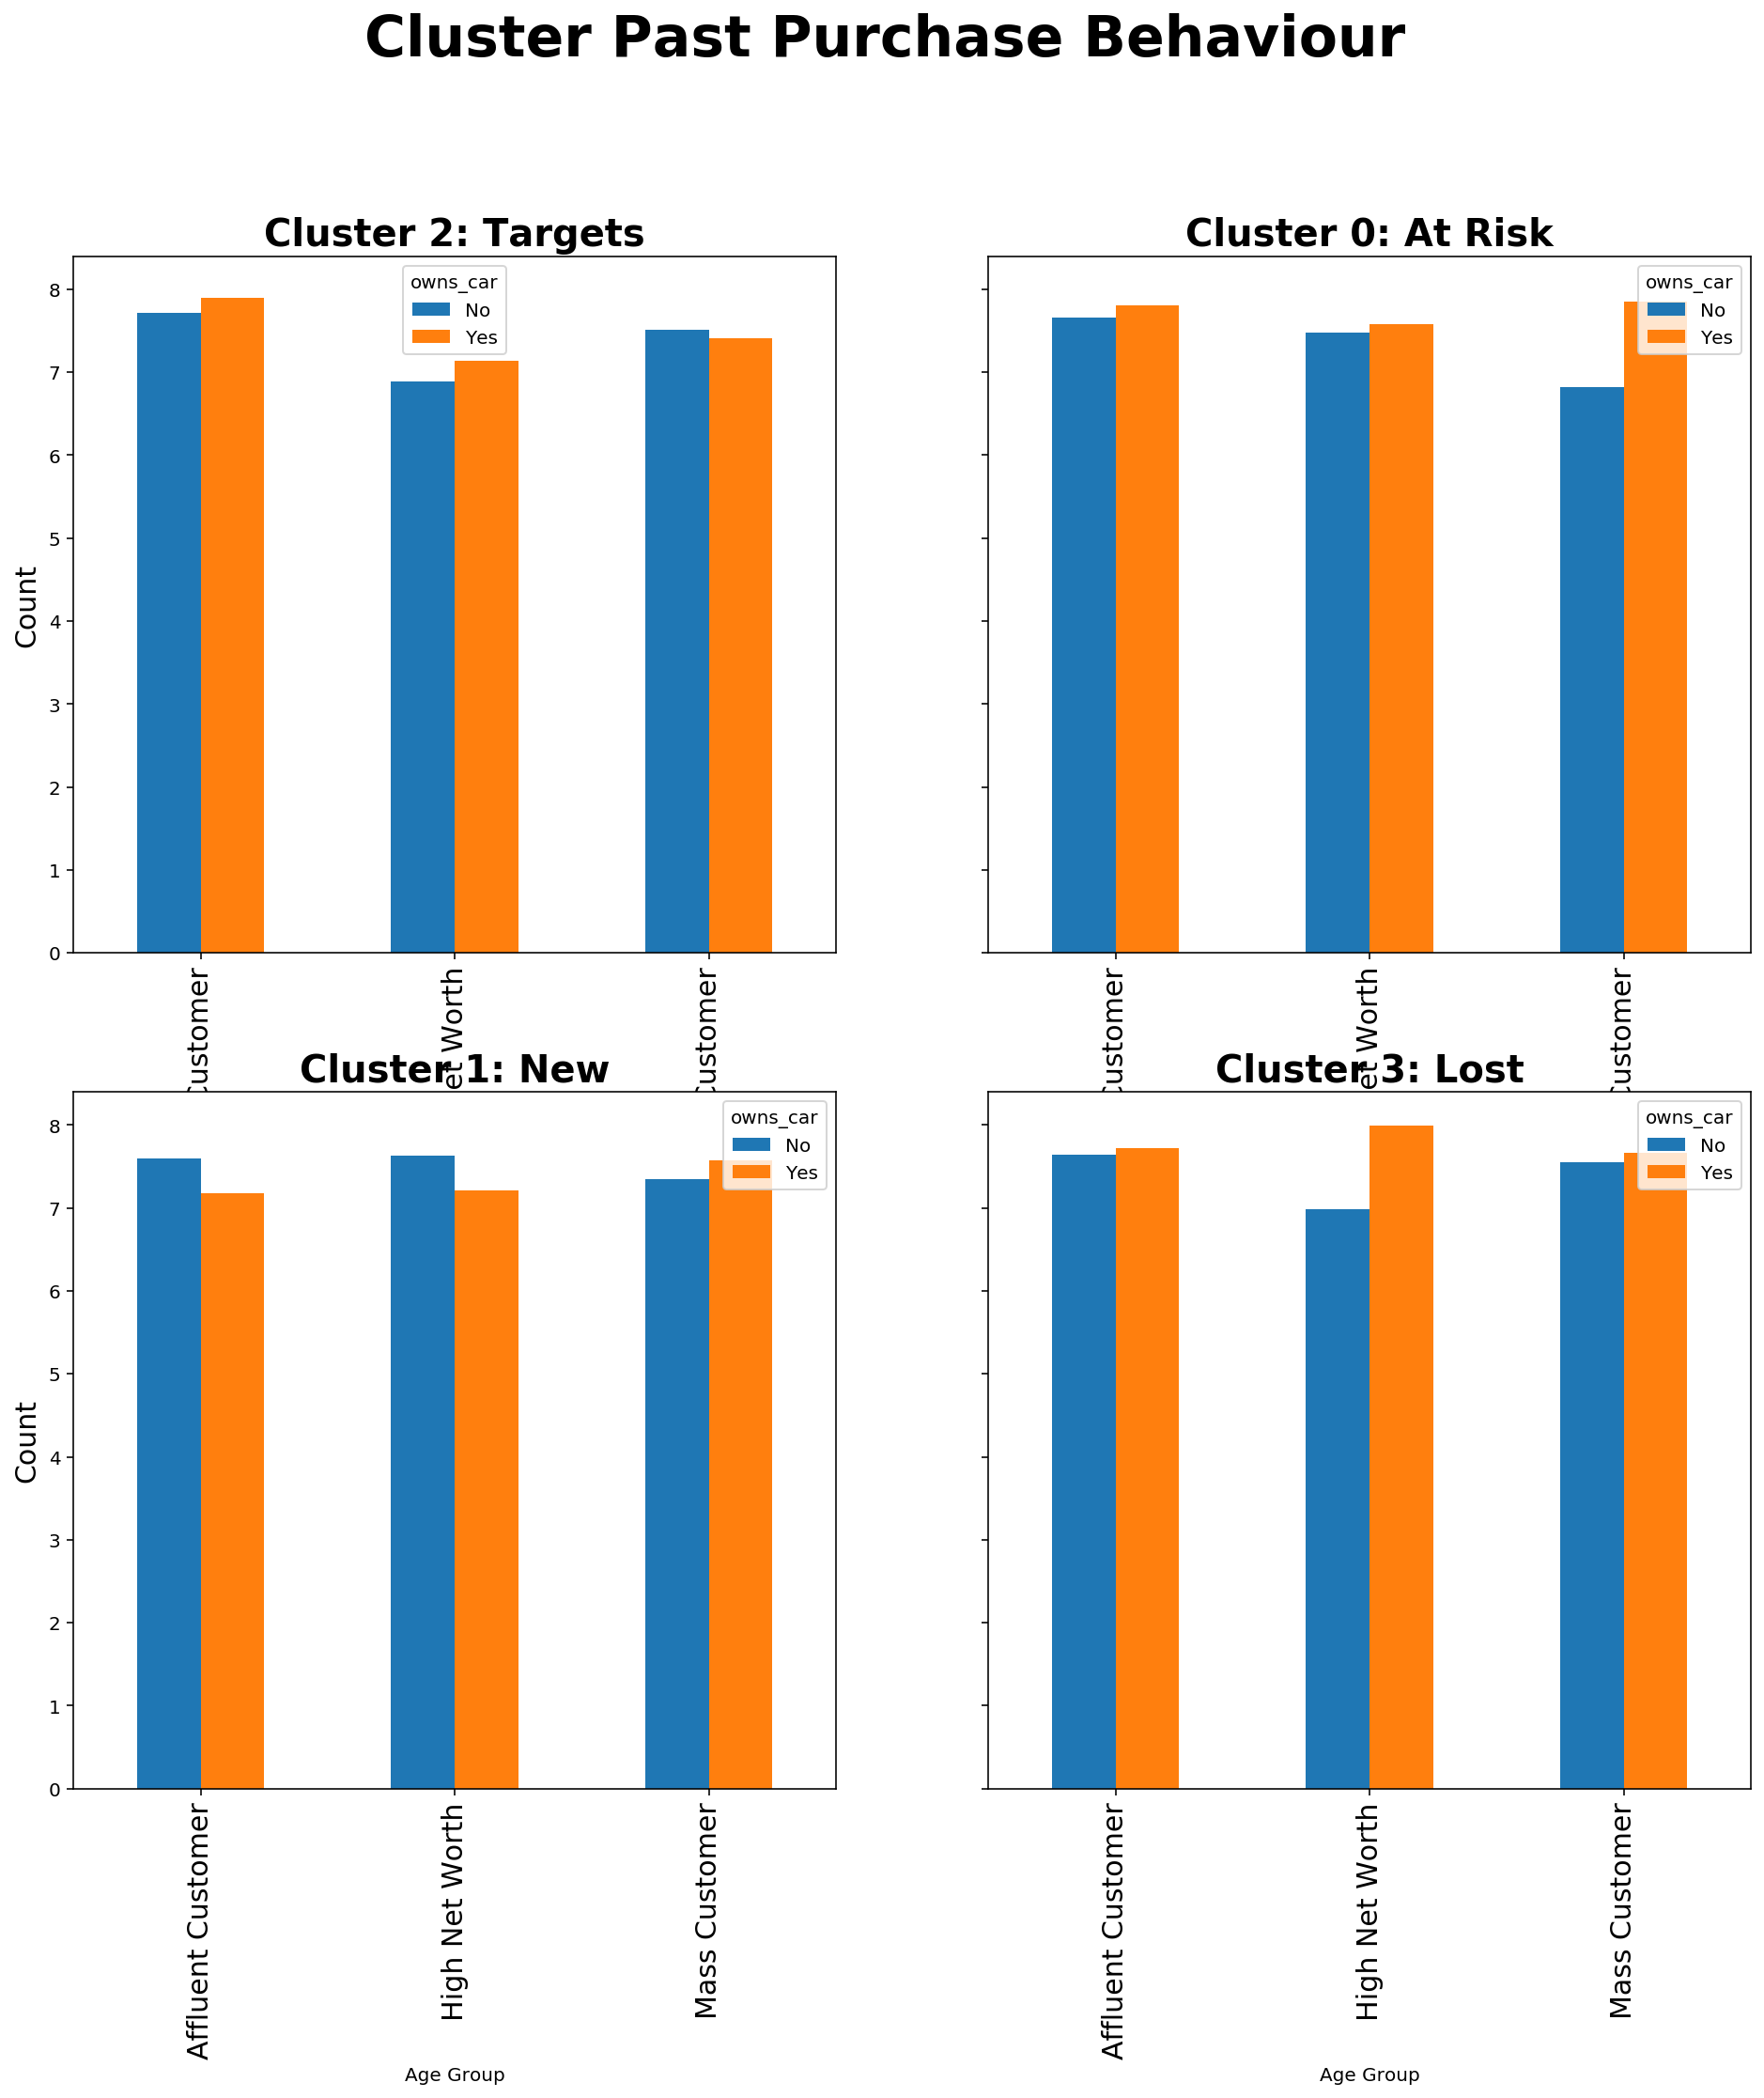

In [74]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey=True, figsize=(16,15))
fig.suptitle('Cluster Past Purchase Behaviour', size=30, fontweight='bold', y=1);

cluster_data = RFM.groupby('cluster')

atrisk = full_clustered.loc[full_clustered['cluster'] == 0]
new = full_clustered.loc[full_clustered['cluster'] == 1]
lost = full_clustered.loc[full_clustered['cluster'] == 3]

target_customers.groupby(['wealth_segment',
                          'owns_car'])['property_valuation'].mean().sort_values(ascending=False).unstack().plot.bar(ax=ax1); 
ax1.set_title('Cluster 2: Targets',fontweight="bold", size=20) 
ax1.set_ylabel('Count', fontsize = 15) 
ax1.set_xlabel('Age Group', fontsize = 10) 

atrisk.groupby(['wealth_segment',
                'owns_car'])['property_valuation'].mean().sort_values(ascending=False).unstack().plot.bar(ax=ax2); 
ax2.set_title('Cluster 0: At Risk',fontweight="bold", size=20) 
ax2.set_ylabel('Count', fontsize = 15) 
ax2.set_xlabel('Age Group', fontsize = 10) 

new.groupby(['wealth_segment',
             'owns_car'])['property_valuation'].mean().sort_values(ascending=False).unstack().plot.bar(ax=ax3); 
ax3.set_title('Cluster 1: New',fontweight="bold", size=20) 
ax3.set_ylabel('Count', fontsize = 15) 
ax3.set_xlabel('Age Group', fontsize = 10) 

lost.groupby(['wealth_segment',
              'owns_car'])['property_valuation'].mean().sort_values(ascending=False).unstack().plot.bar(ax=ax4); 
ax4.set_title('Cluster 3: Lost',fontweight="bold", size=20) 
ax4.set_ylabel('Count', fontsize = 15) 
ax4.set_xlabel('Age Group', fontsize = 10) 
#----------------------------------------------------------------------------------------

In [75]:
print(target_customers['past_3_years_bike_related_purchases'].mean())
print(atrisk['past_3_years_bike_related_purchases'].mean())
print(new['past_3_years_bike_related_purchases'].mean())
print(lost['past_3_years_bike_related_purchases'].mean())

49.88382687927107
48.58203125
52.2780612244898
46.972727272727276


Text(0.5, 0, 'Age Group')

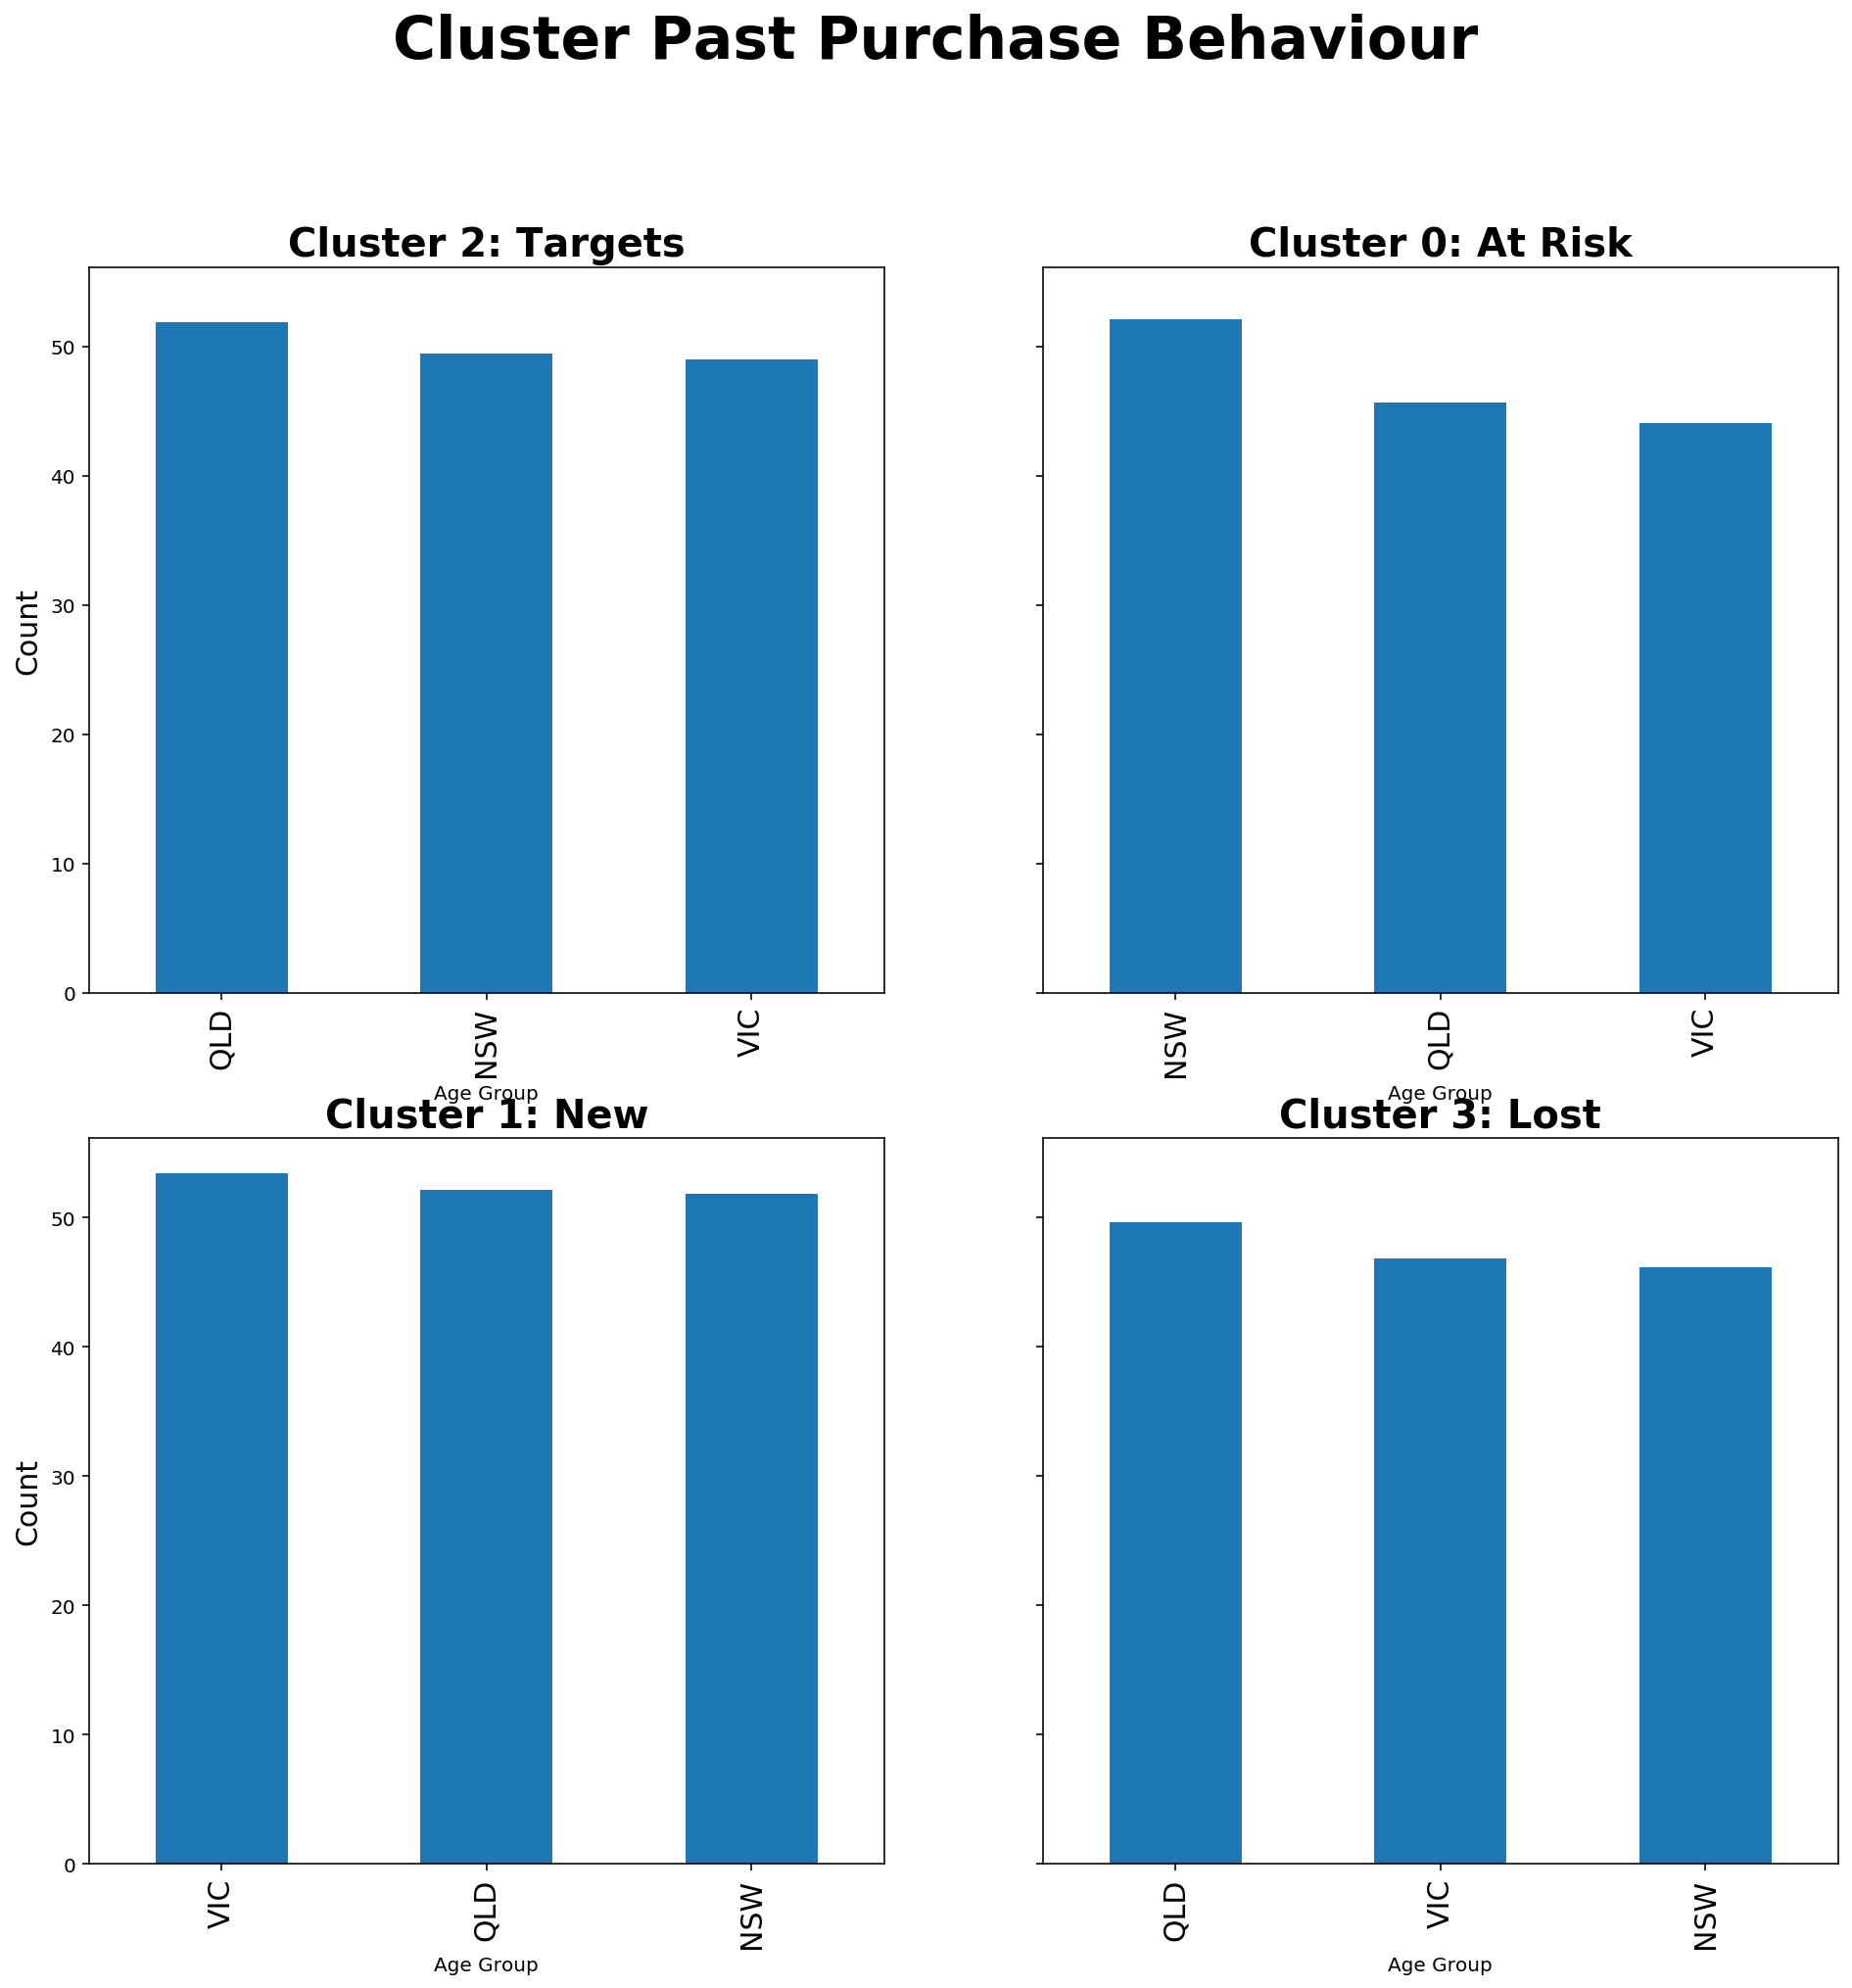

In [76]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey=True, figsize=(16,15))
fig.suptitle('Cluster Past Purchase Behaviour', size=30, fontweight='bold', y=1);

cluster_data = RFM.groupby('cluster')

atrisk = full_clustered.loc[full_clustered['cluster'] == 0]
new = full_clustered.loc[full_clustered['cluster'] == 1]
lost = full_clustered.loc[full_clustered['cluster'] == 3]

target_customers.groupby(['state'])['past_3_years_bike_related_purchases'].mean().sort_values(ascending=False).plot.bar(ax=ax1); 
ax1.set_title('Cluster 2: Targets',fontweight="bold", size=20) 
ax1.set_ylabel('Count', fontsize = 15) 
ax1.set_xlabel('Age Group', fontsize = 10) 

atrisk.groupby(['state'])['past_3_years_bike_related_purchases'].mean().sort_values(ascending=False).plot.bar(ax=ax2); 
ax2.set_title('Cluster 0: At Risk',fontweight="bold", size=20) 
ax2.set_ylabel('Count', fontsize = 15) 
ax2.set_xlabel('Age Group', fontsize = 10) 

new.groupby(['state'])['past_3_years_bike_related_purchases'].mean().sort_values(ascending=False).plot.bar(ax=ax3); 
ax3.set_title('Cluster 1: New',fontweight="bold", size=20) 
ax3.set_ylabel('Count', fontsize = 15) 
ax3.set_xlabel('Age Group', fontsize = 10) 


lost.groupby(['state'])['past_3_years_bike_related_purchases'].mean().sort_values(ascending=False).plot.bar(ax=ax4); 
ax4.set_title('Cluster 3: Lost',fontweight="bold", size=20) 
ax4.set_ylabel('Count', fontsize = 15) 
ax4.set_xlabel('Age Group', fontsize = 10) 
#----------------------------------------------------------------------------------------

# Predicting New Customers

To predict what segments new customers will potentially be grouped in, we can apply machine learning models to our old customer data to find patterns for each segment.

A simple Decision Tree can be used due to minimal preprocessing required and also its ability to generate explainable decision rules.

In [77]:
# Export datasets

full_clustered.to_csv('full_clustered.csv', index=False)
target_customers.to_csv('high_value.csv', index=False)
RFM.to_csv('RFMs.csv', index=True)

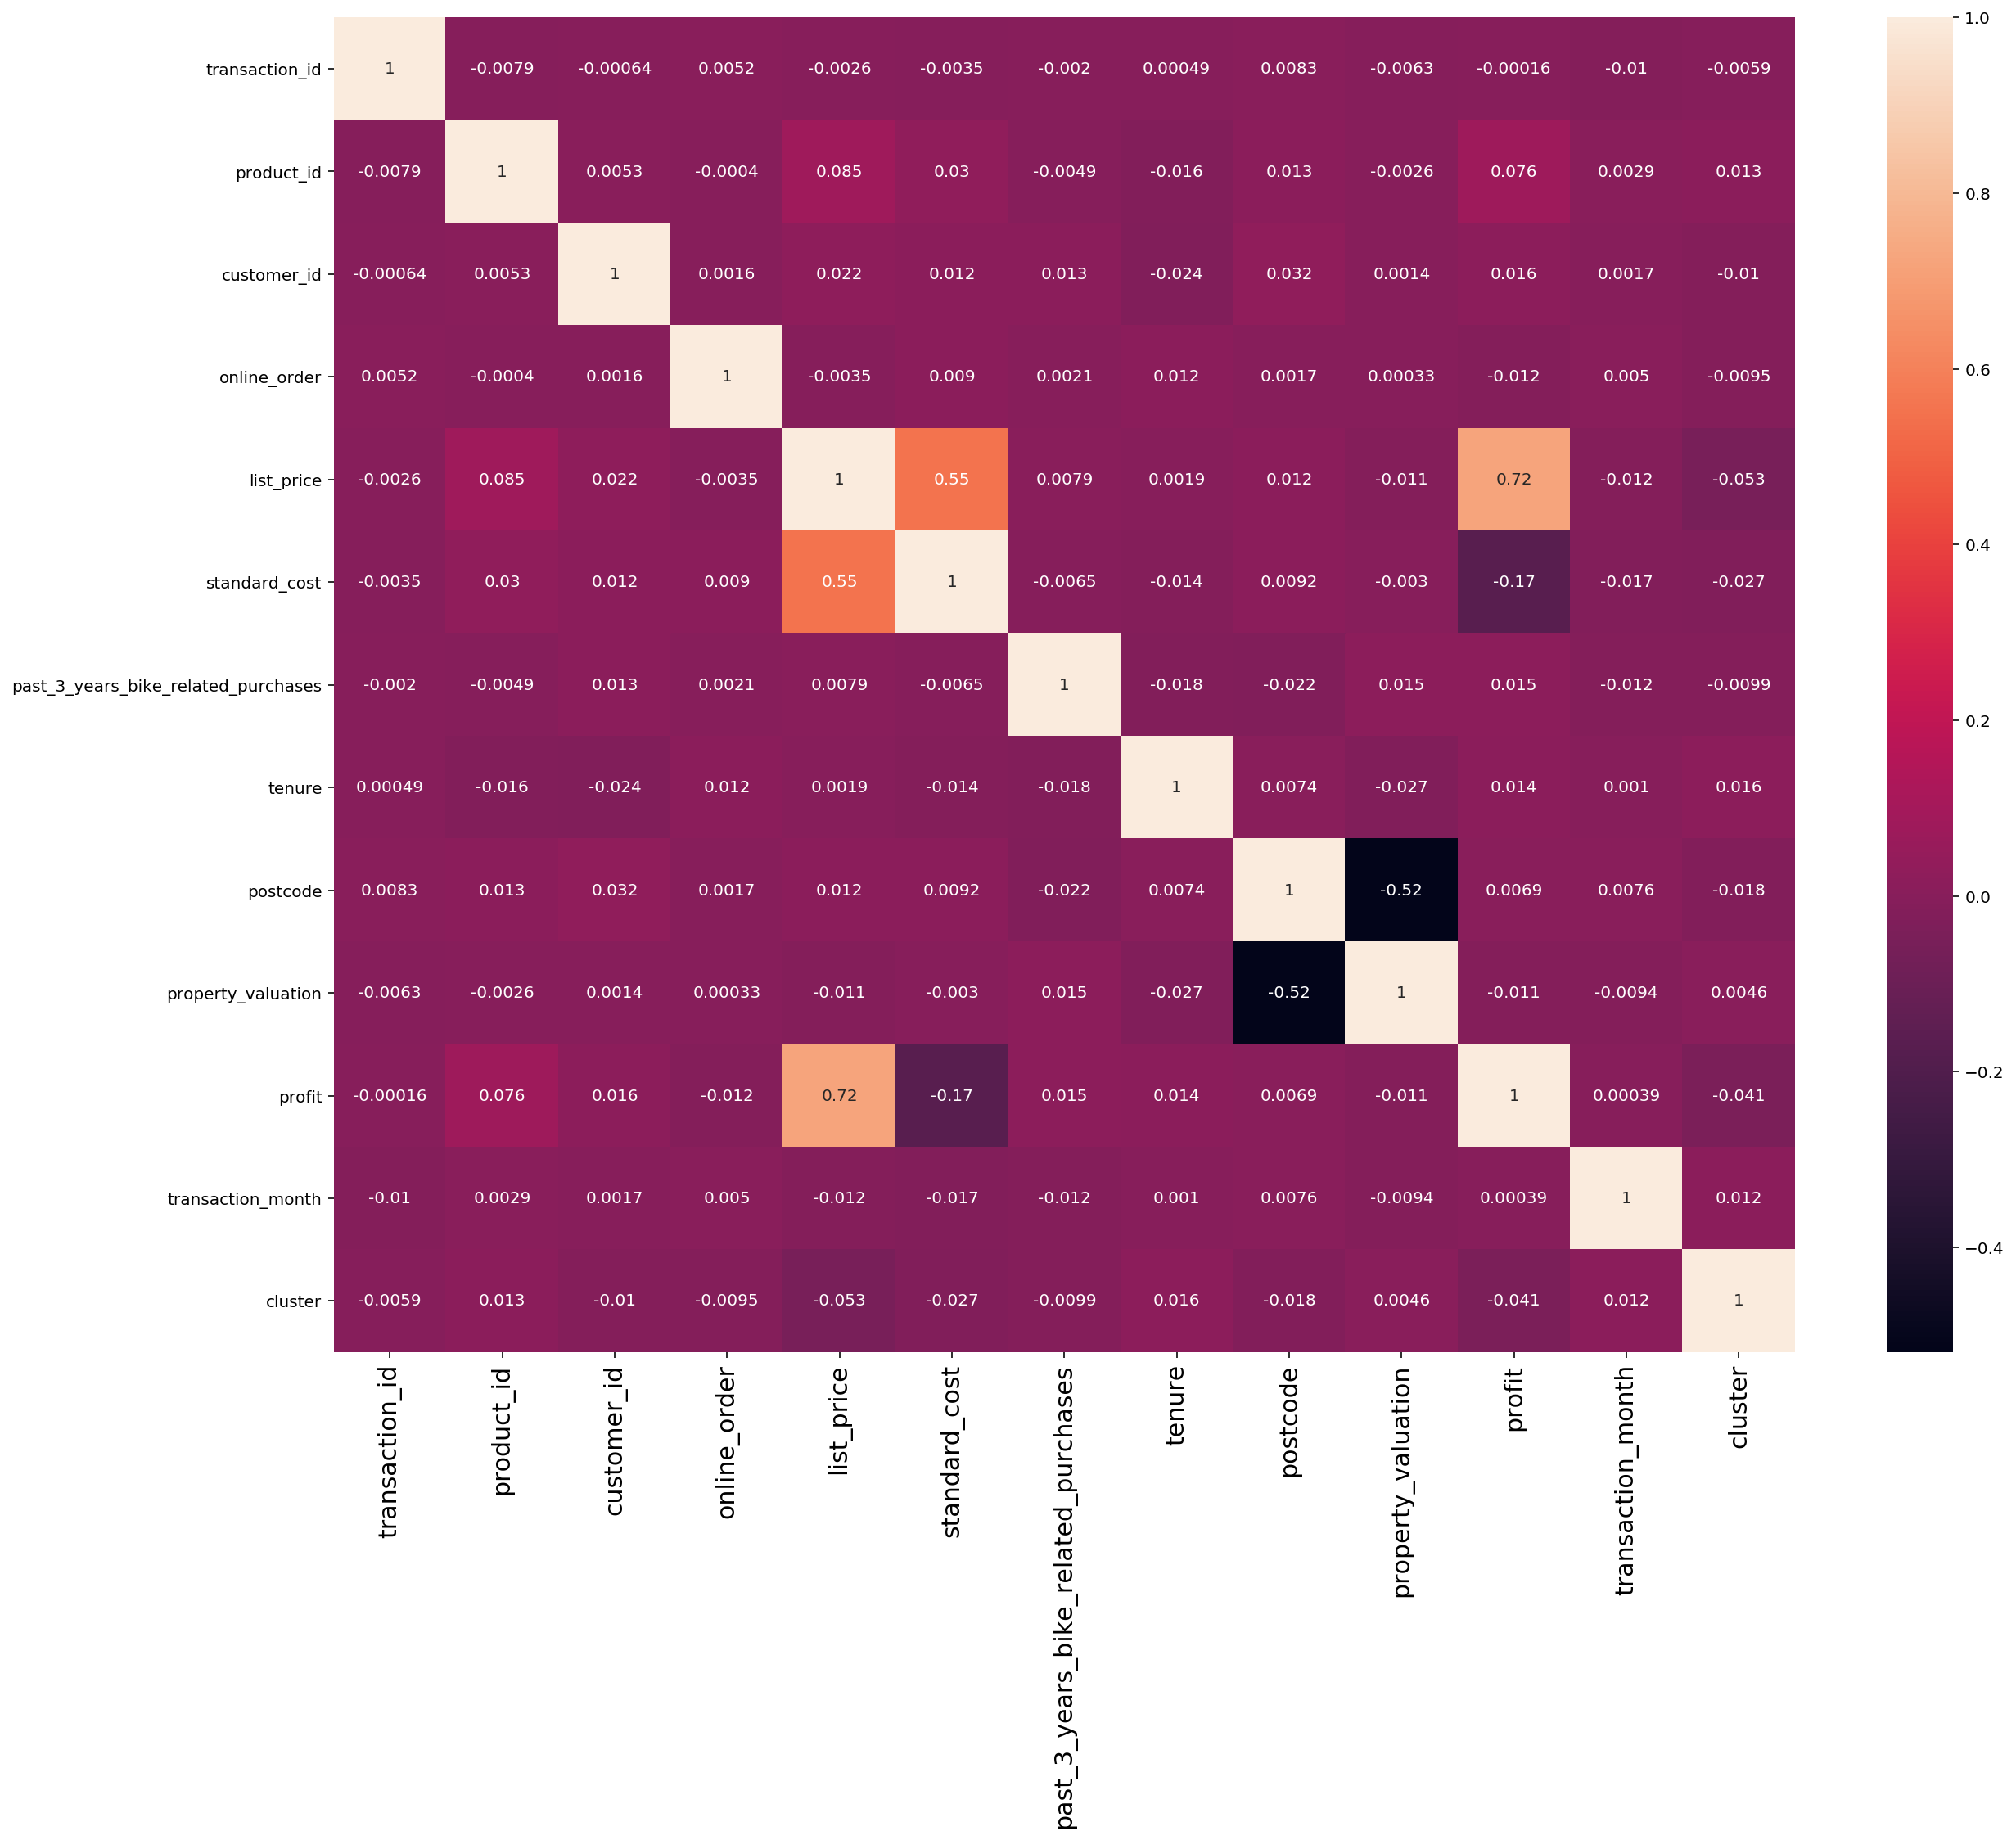

In [88]:
corr = full_clustered.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True, 
            )




In [84]:
full_clustered.corr()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,profit,transaction_month,cluster
transaction_id,1.000000,-0.007881,-0.000637,0.005161,-0.002561,-0.003457,-0.002028,0.000488,0.008310,-0.006345,-0.000164,-0.010497,-0.005861
product_id,-0.007881,1.000000,0.005345,-0.000399,0.085144,0.029928,-0.004890,-0.016190,0.013372,-0.002592,0.075965,0.002916,0.013104
customer_id,-0.000637,0.005345,1.000000,0.001617,0.021986,0.011792,0.012612,-0.023887,0.032477,0.001409,0.016246,0.001659,-0.009991
online_order,0.005161,-0.000399,0.001617,1.000000,-0.003532,0.009001,0.002109,0.011721,0.001729,0.000331,-0.011647,0.005041,-0.009487
list_price,-0.002561,0.085144,0.021986,-0.003532,1.000000,0.554690,0.007950,0.001911,0.012264,-0.011227,0.723659,-0.011857,-0.053144
standard_cost,-0.003457,0.029928,0.011792,0.009001,0.554690,1.000000,-0.006522,-0.014170,0.009200,-0.002984,-0.172845,-0.017390,-0.026524
past_3_years_bike_related_purchases,-0.002028,-0.004890,0.012612,0.002109,0.007950,-0.006522,1.000000,-0.017910,-0.021530,0.015151,0.014820,-0.011502,-0.009923
tenure,0.000488,-0.016190,-0.023887,0.011721,0.001911,-0.014170,-0.017910,1.000000,0.007353,-0.026602,0.014016,0.001003,0.015510
postcode,0.008310,0.013372,0.032477,0.001729,0.012264,0.009200,-0.021530,0.007353,1.000000,-0.519477,0.006886,0.007592,-0.017702
property_valuation,-0.006345,-0.002592,0.001409,0.000331,-0.011227,-0.002984,0.015151,-0.026602,-0.519477,1.000000,-0.010815,-0.009403,0.004616
